In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mid_simulations.simulation_funcs import (
    create_contrasts,
    create_design_matrices,
    est_eff_vif_all_subs,
    get_beta_dicts,
    get_subdata_long,
    make_analysis_label,
    sim_group_models_parallel,
)
from mid_simulations.simulation_plotting import (
    plot_bias,
    plot_bias_significance,
    plot_design_ordered_regressors,
    plot_dict_of_results,
    plot_error_grid,
    plot_results,
)

In [ ]:
a = 'boo'

In [2]:
# Change this to the path where you want to save the output figures
figure_output_path = (
    '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures'
)
# Change this to AHRB if you're using the AHRB data (distributed with this repo)
dataset = 'ABCD'

## Design matrices and contrasts

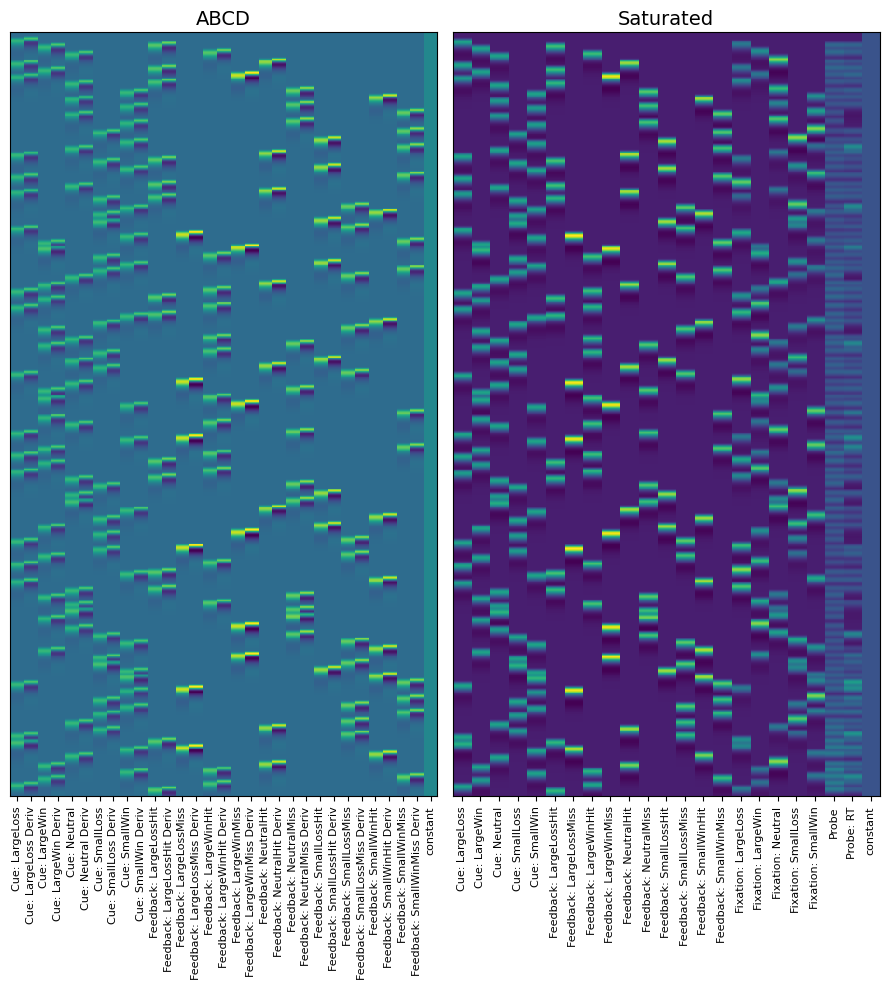

In [3]:
fig_path = f'{figure_output_path}/design_matrices.pdf'
sub = 4
events = get_subdata_long(sub, dataset=dataset)
designs = create_design_matrices(events, oversampling=50, tr=0.8)

fig, ax = plt.subplots(1, 2, figsize=(9, 10))
ax_flat = ax.flatten()
for i, desname in enumerate(['CueYesDeriv', 'Saturated']):
    plot_label = desname if desname == 'Saturated' else 'ABCD'
    plot_design_ordered_regressors(designs[desname], plot_label, ax=ax_flat[i])
    ax_flat[i].set_title(plot_label, fontsize=14)
    ax_flat[i].tick_params(
        axis='x',
        bottom=True,
        top=False,
        labelbottom=True,
        labeltop=False,
        rotation=90,
        labelsize=8,
    )
    ax_flat[i].tick_params(axis='y', labelsize=8)
    ax_flat[i].yaxis.set_ticks([])
    ax_flat[i].yaxis.set_ticklabels([])
    ax_flat[i].set_ylabel('')
    for label in ax_flat[i].get_xticklabels():
        label.set_horizontalalignment('center')
fig.align_titles()
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [4]:
contrast_strings, contrasts_matrices, c_pinv_xmats = create_contrasts(designs)
interesting_contrast_substr = ['-']
for key, contrasts in contrast_strings.items():
    print(f'\n Contrasts for {key} model')
    for contrast_name, contrast_string in contrasts.items():
        if any(x in contrast_name for x in interesting_contrast_substr):
            print(f'{contrast_name}: {contrast_string}')


 Contrasts for Saturated model
Cue: W-base: .5 * Cue_LargeWin  + .5 * Cue_SmallWin
Cue: W-Neut: .5 * Cue_LargeWin  + .5 * Cue_SmallWin - 1 * Cue_Neutral
Cue: LW-Neut: 1 * Cue_LargeWin - 1 * Cue_Neutral
FB: WHit-NeutHit: .5 * Feedback_LargeWinHit + .5 * Feedback_SmallWinHit - 1 * Feedback_NeutralHit
FB: LWHit-LWMiss: 1 * Feedback_LargeWinHit - 1 * Feedback_LargeWinMiss

 Contrasts for CueNoDeriv model
Cue: W-base: .5 * Cue_LargeWin  + .5 * Cue_SmallWin
Cue: W-Neut: .5 * Cue_LargeWin  + .5 * Cue_SmallWin - 1 * Cue_Neutral
Cue: LW-Neut: 1 * Cue_LargeWin - 1 * Cue_Neutral
FB: WHit-NeutHit: .5 * Feedback_LargeWinHit + .5 * Feedback_SmallWinHit - 1 * Feedback_NeutralHit
FB: LWHit-LWMiss: 1 * Feedback_LargeWinHit - 1 * Feedback_LargeWinMiss

 Contrasts for CueYesDeriv model
Cue: W-base: .5 * Cue_LargeWin  + .5 * Cue_SmallWin
Cue: W-Neut: .5 * Cue_LargeWin  + .5 * Cue_SmallWin - 1 * Cue_Neutral
Cue: LW-Neut: 1 * Cue_LargeWin - 1 * Cue_Neutral
FB: WHit-NeutHit: .5 * Feedback_LargeWinHit + .5 *

## Main simulations comparing ABCD to Saturated model

In [5]:
beta_dicts = get_beta_dicts(dataset=dataset)
beta_sub_sd = 1
noise_sd = 1
nsims = 1000
results = {}

for beta_dict in beta_dicts:
    print(beta_dict)
    figure_label = make_analysis_label(beta_dict)
    results[figure_label], _, model_example = sim_group_models_parallel(
        beta_dict,
        noise_sd,
        beta_sub_sd,
        nsims=nsims,
        oversampling=50,
        tr=0.8,
        dataset=dataset,
    )

{}
{'Cue: LargeWin': 0.15, 'Cue: SmallWin': 0.15}
{'Fixation: LargeWin': 0.15, 'Fixation: SmallWin': 0.15}
{'Probe': 0.55}
{'Probe: RT': 0.3}
{'Feedback: LargeWinHit': 0.18, 'Feedback: SmallWinHit': 0.18}


### Rejection rages and estimate distributions
Opaque bars/violins correspond to contrasts that are null, so the error rates should be at 0.05 and t-stat distributions should be centered about 0.

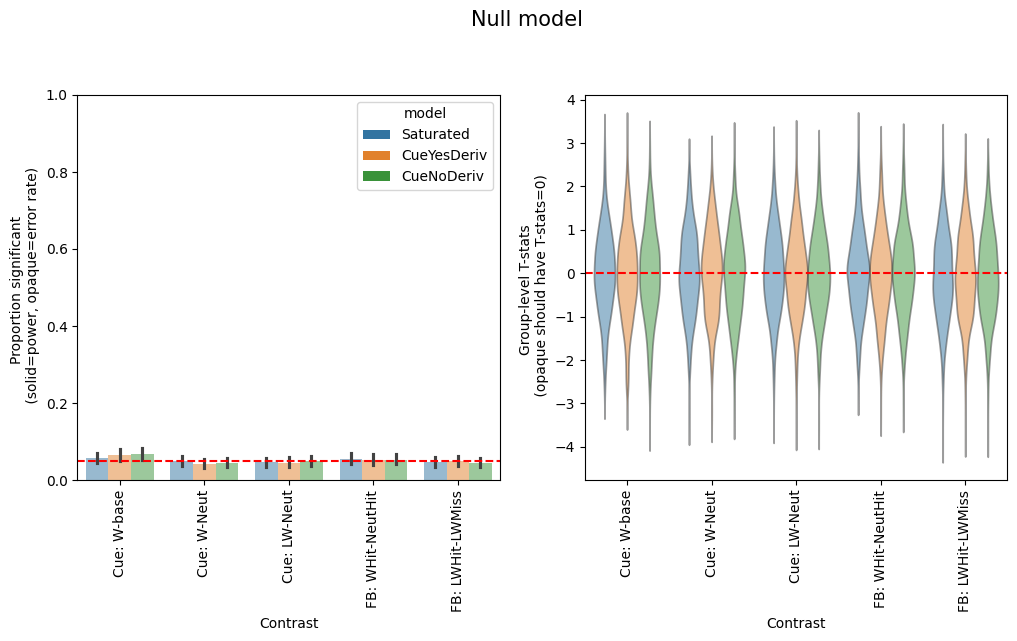

In [6]:
plot_dict_of_results({'Null model': results['Null model']}, contrasts=True)

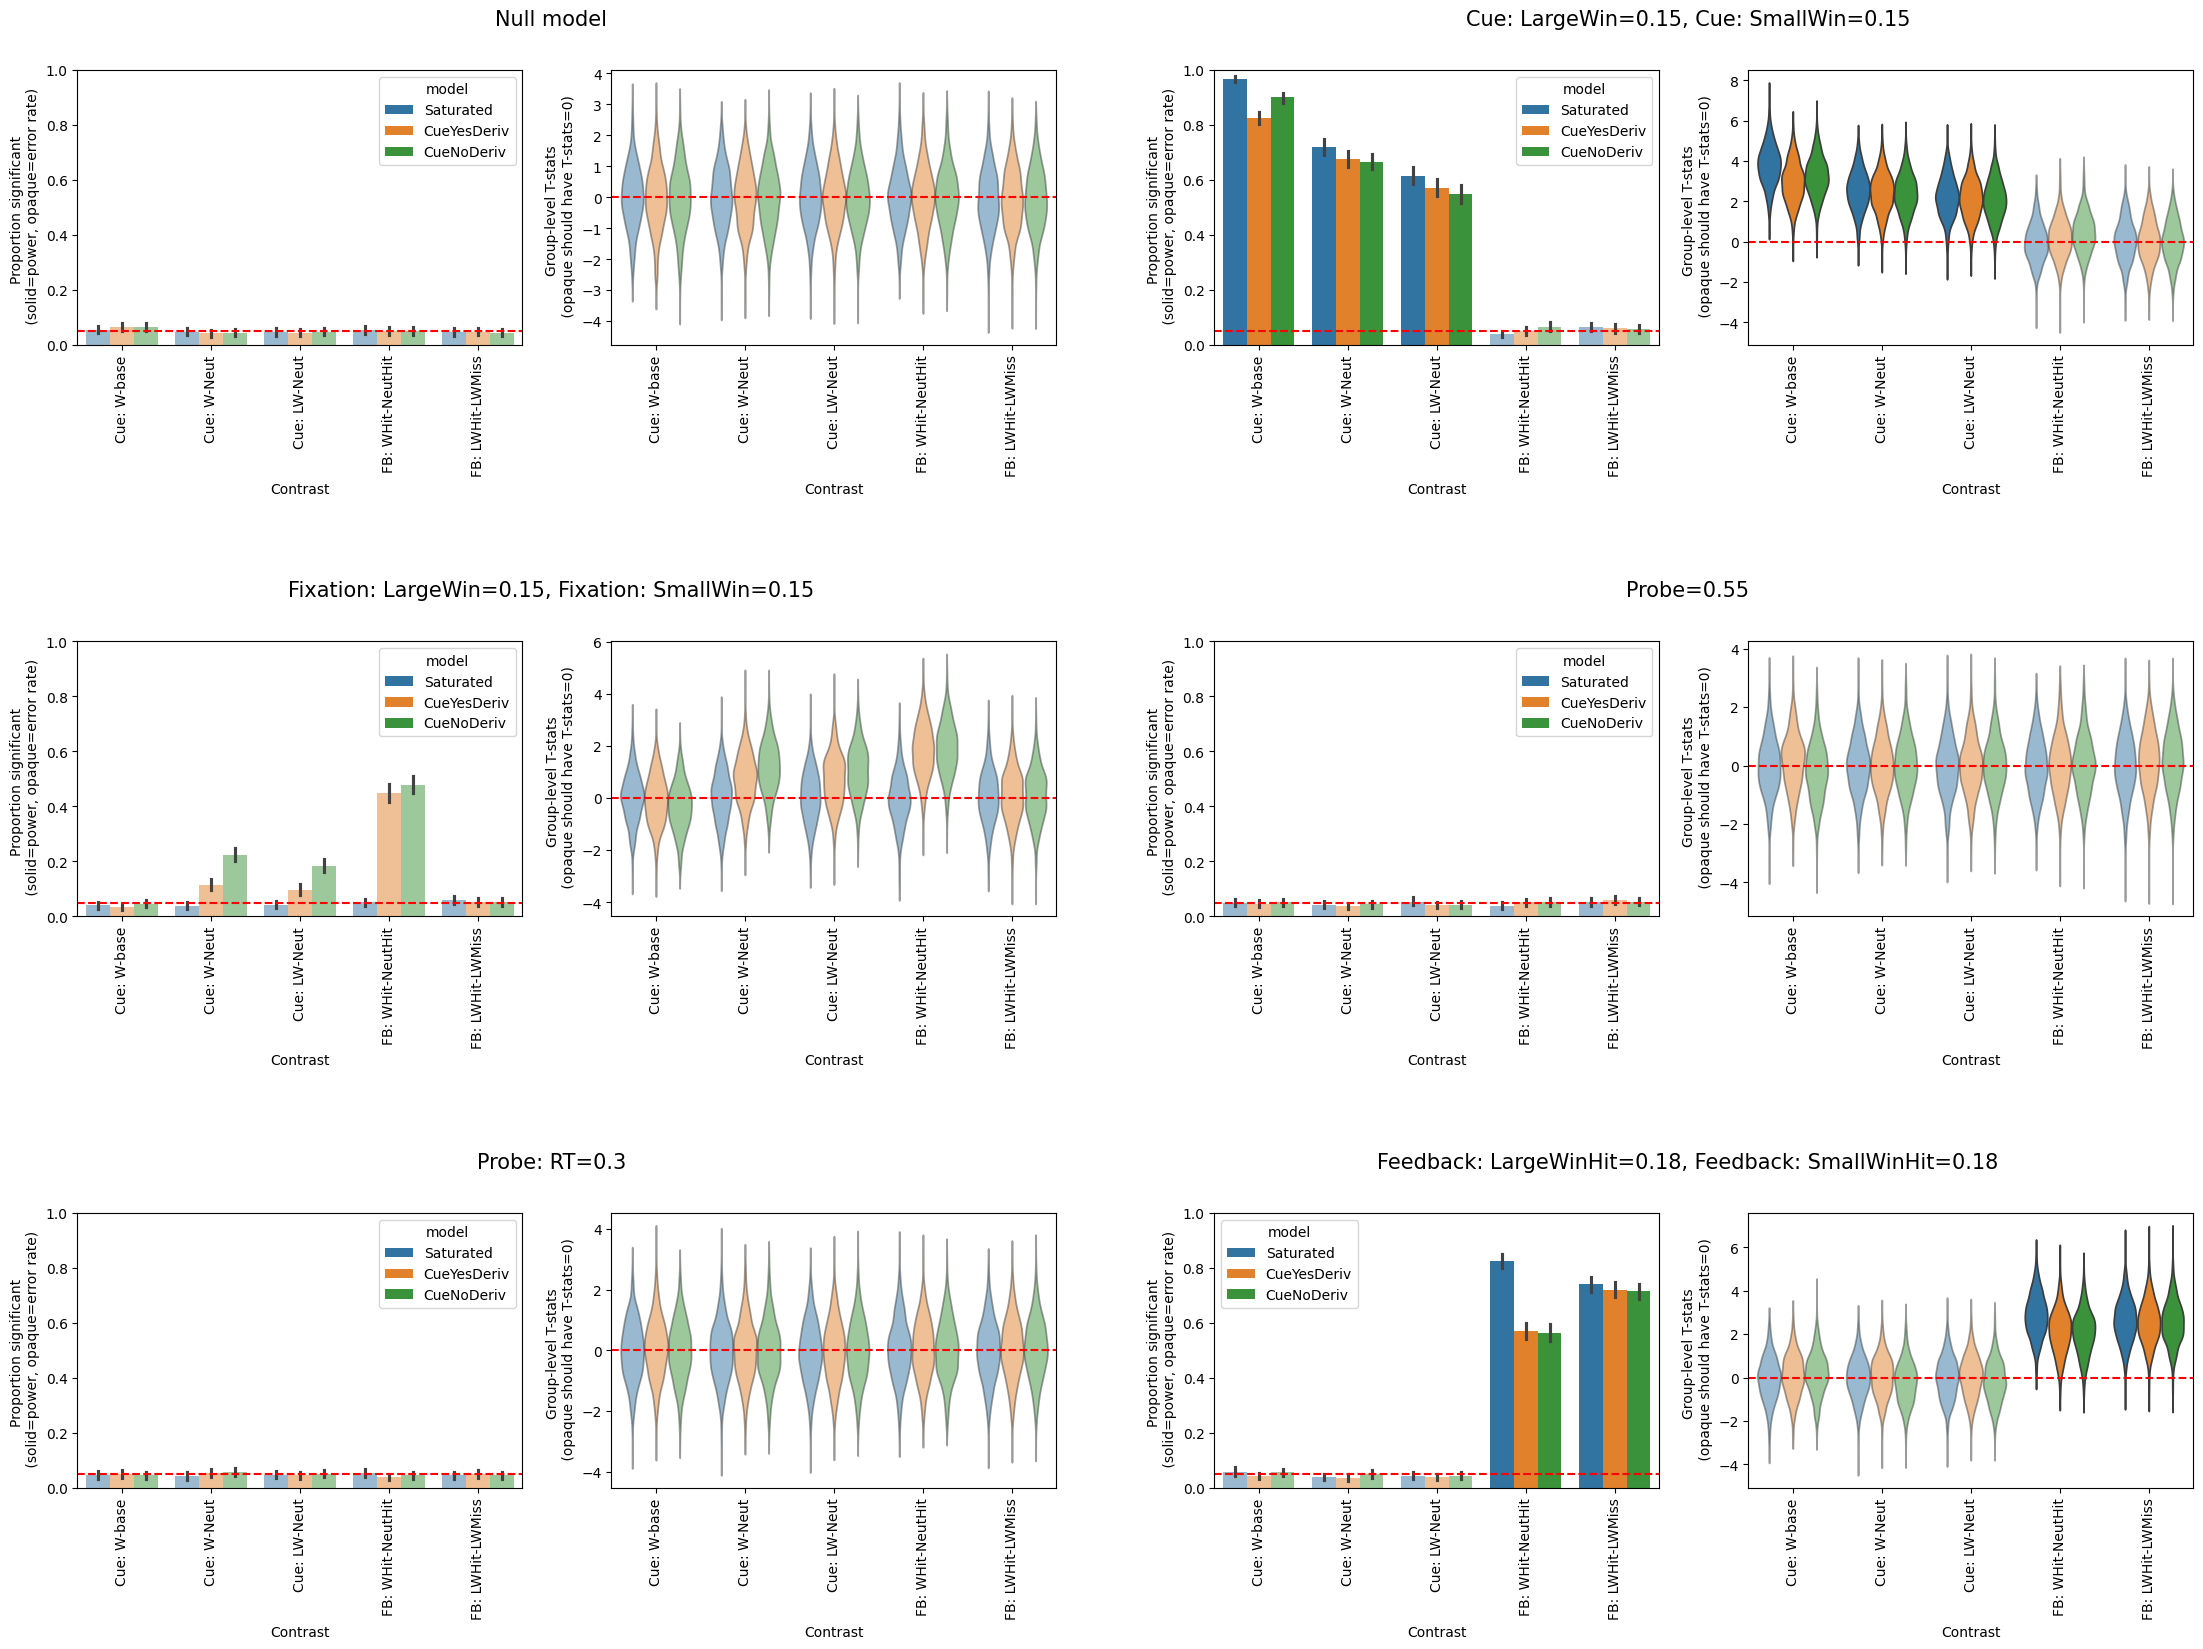

In [7]:
# Plot breaks if you don't enter an even number of results, so I include the null again.
results_plot = results.copy()
if len(results) % 2 != 0:
    results_plot.pop('Null model')
plot_dict_of_results(results_plot, contrasts=True)

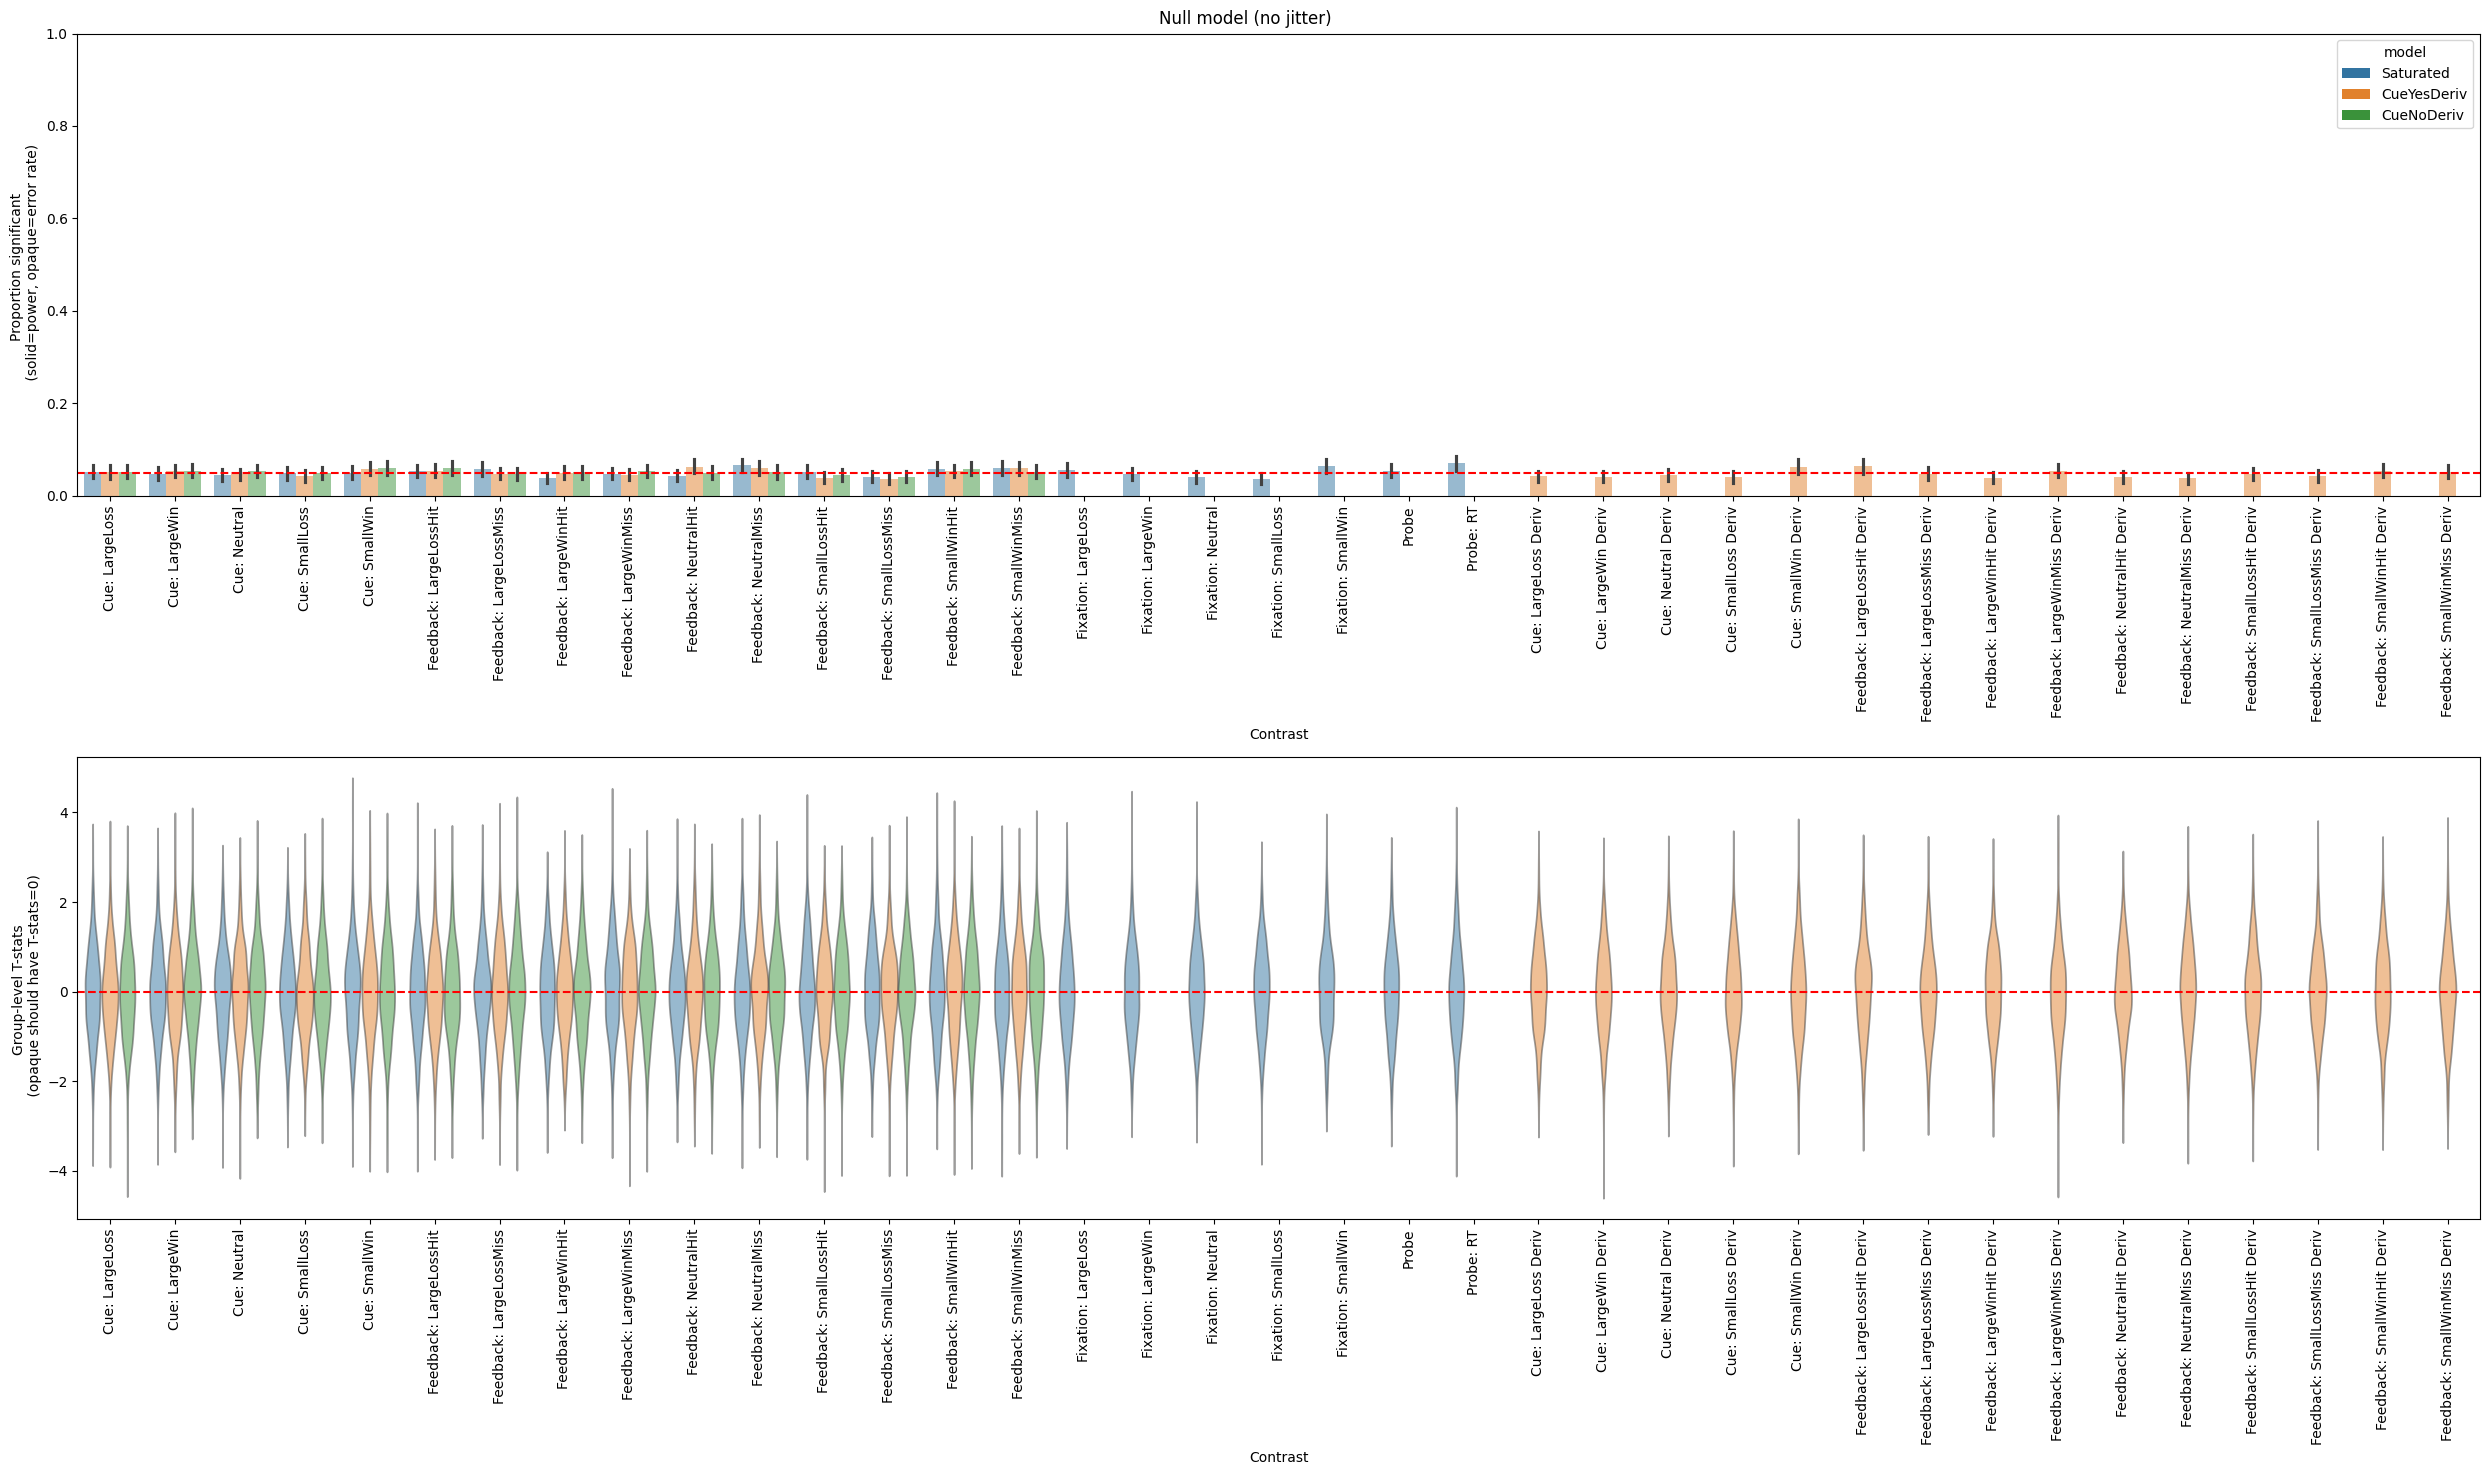

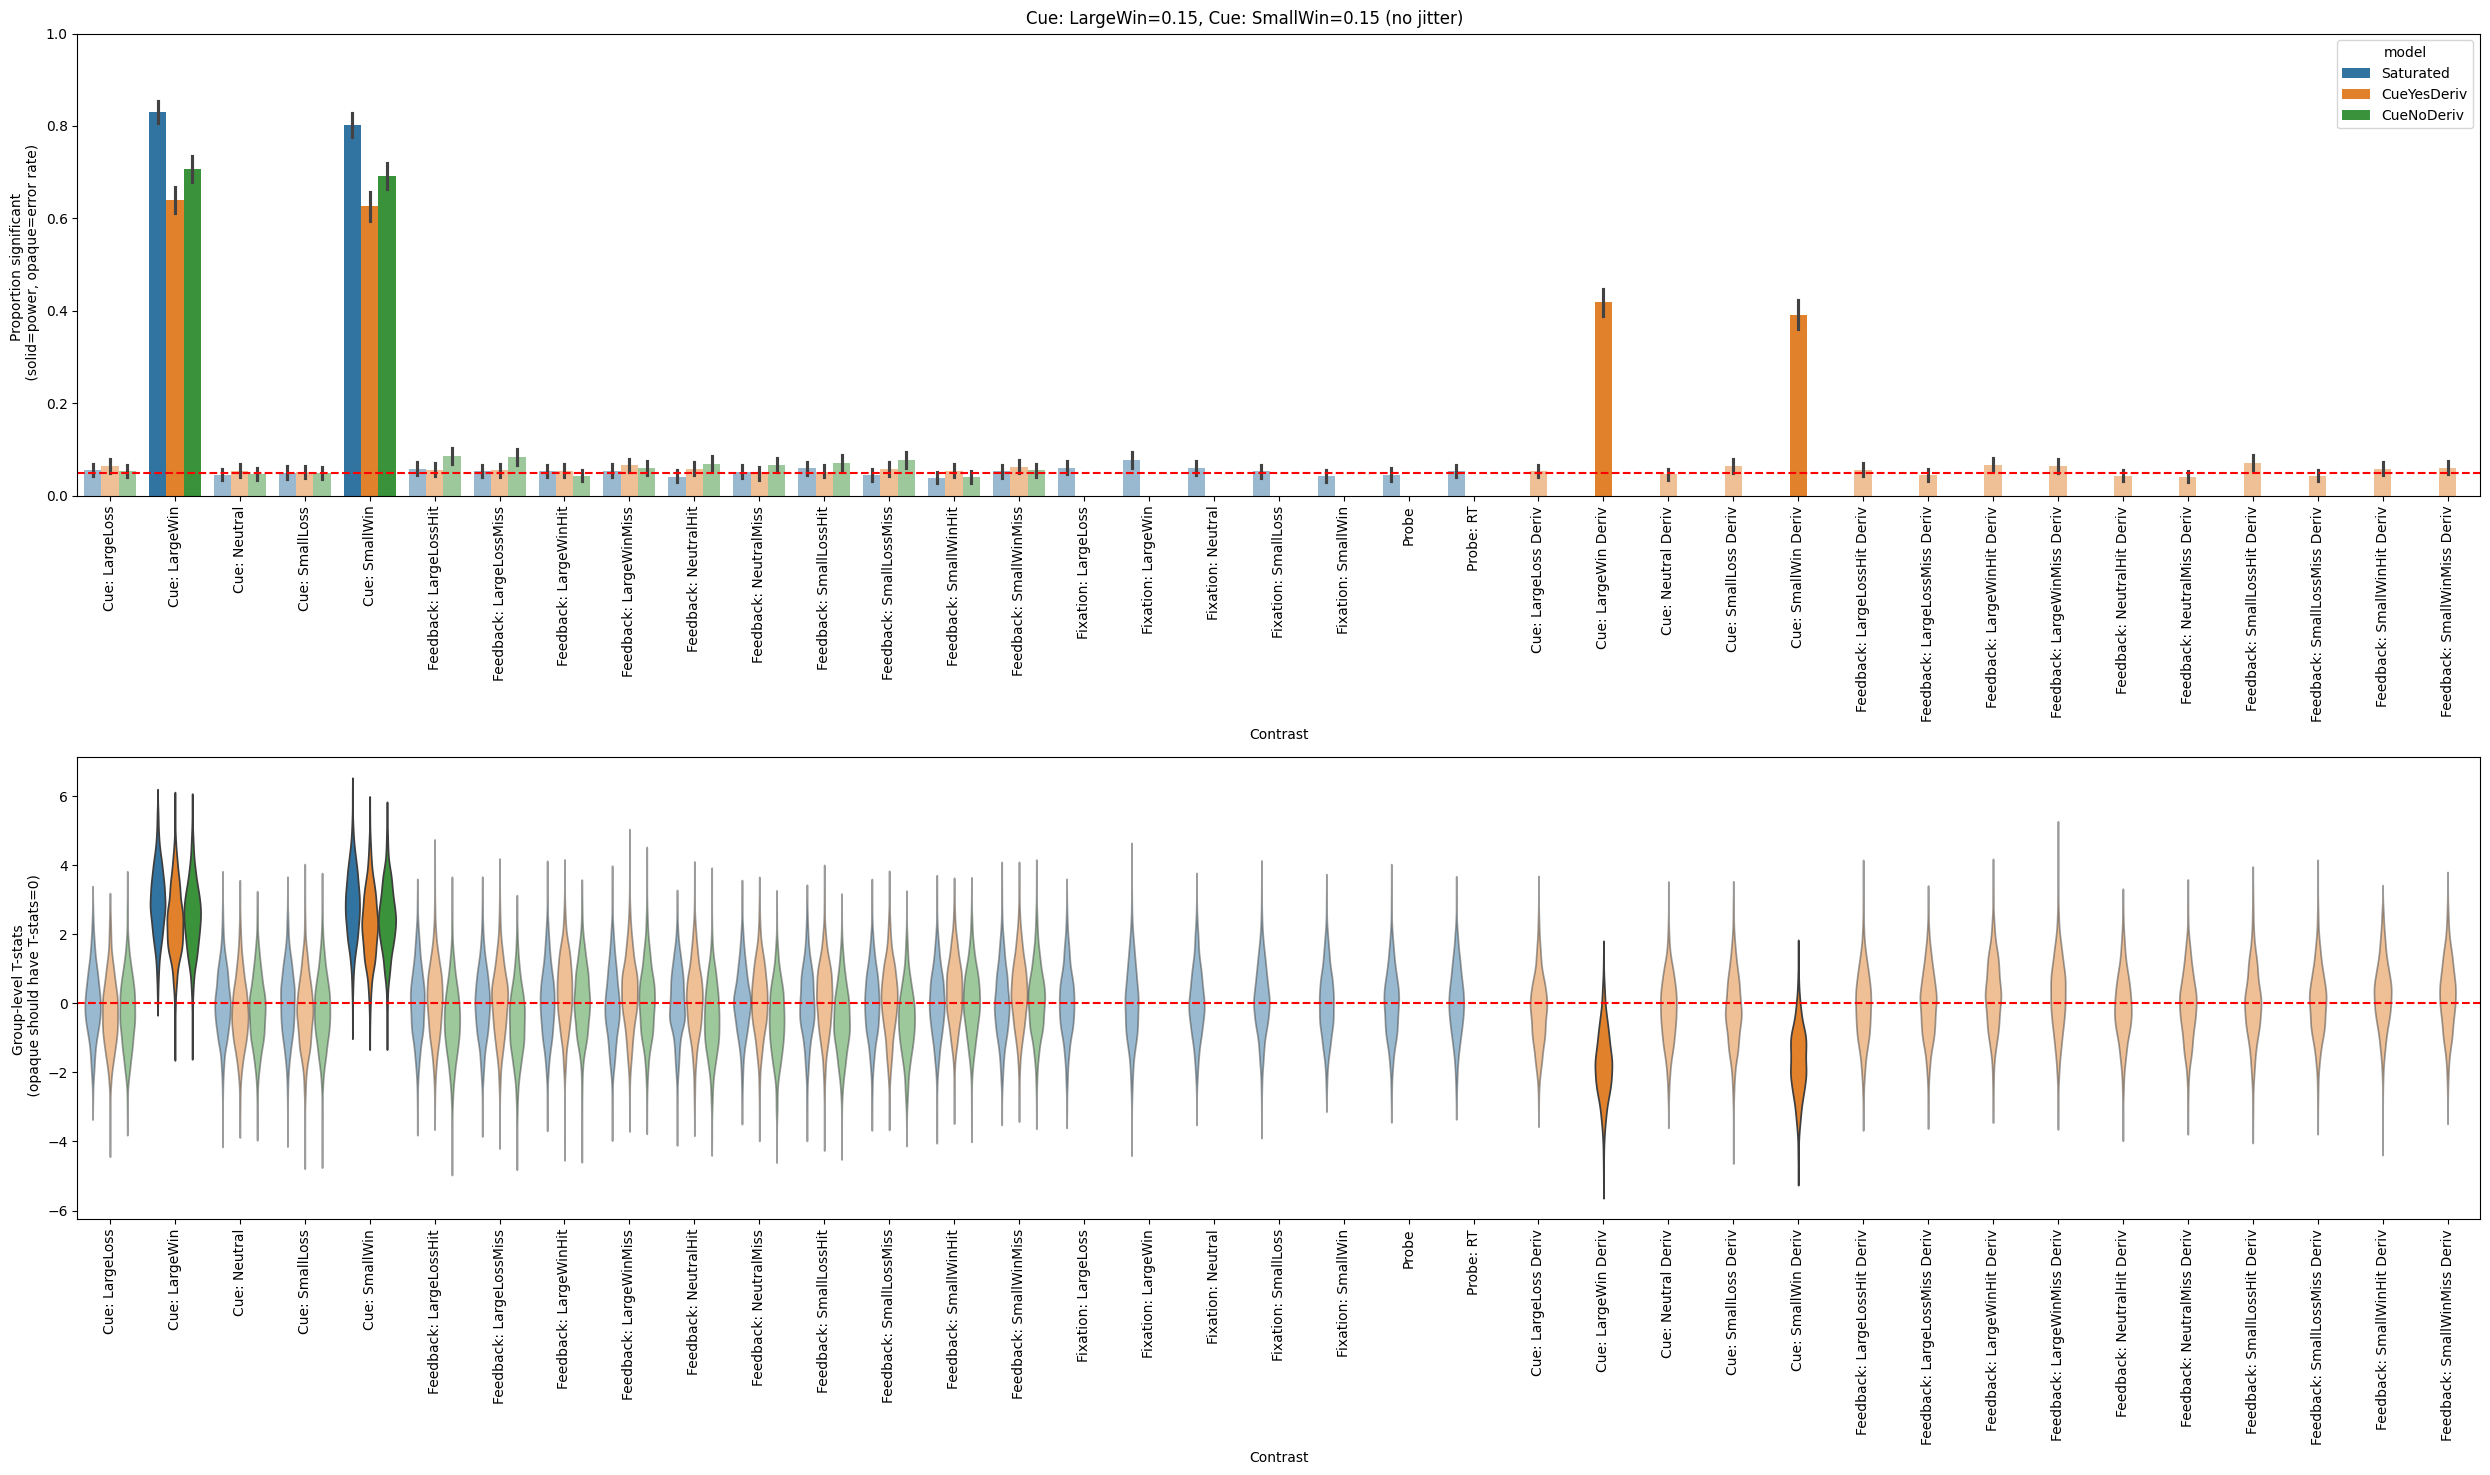

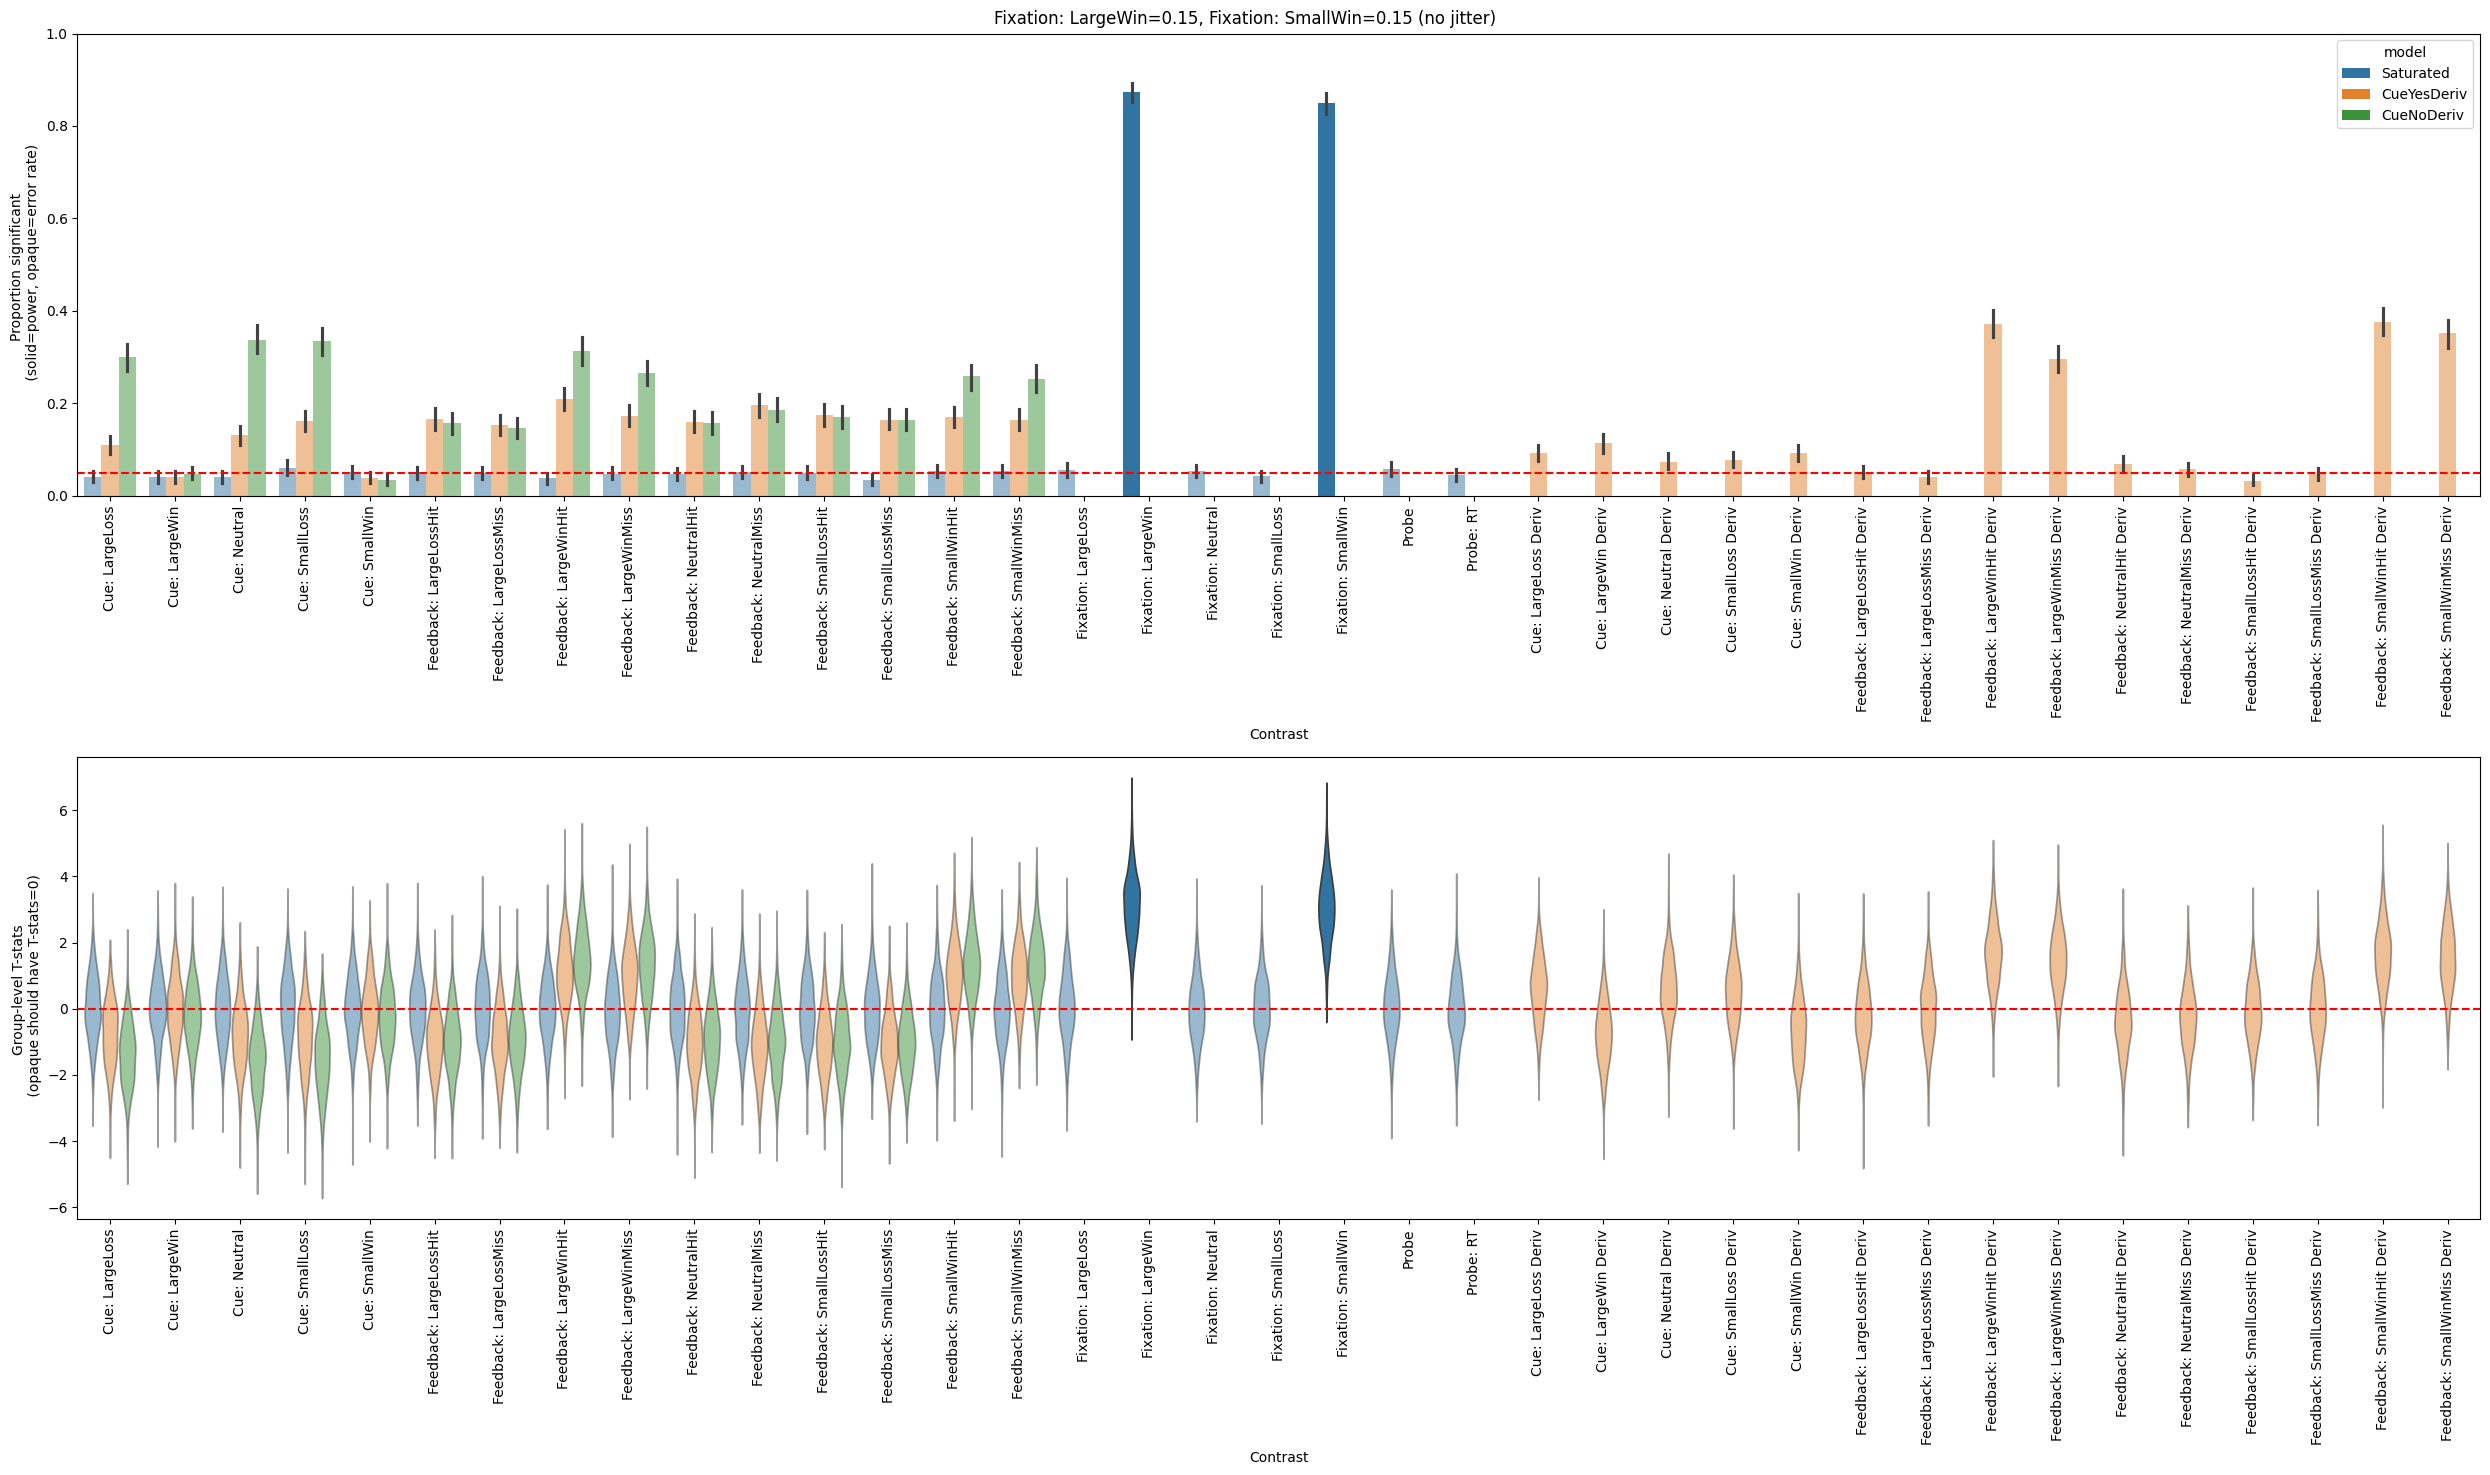

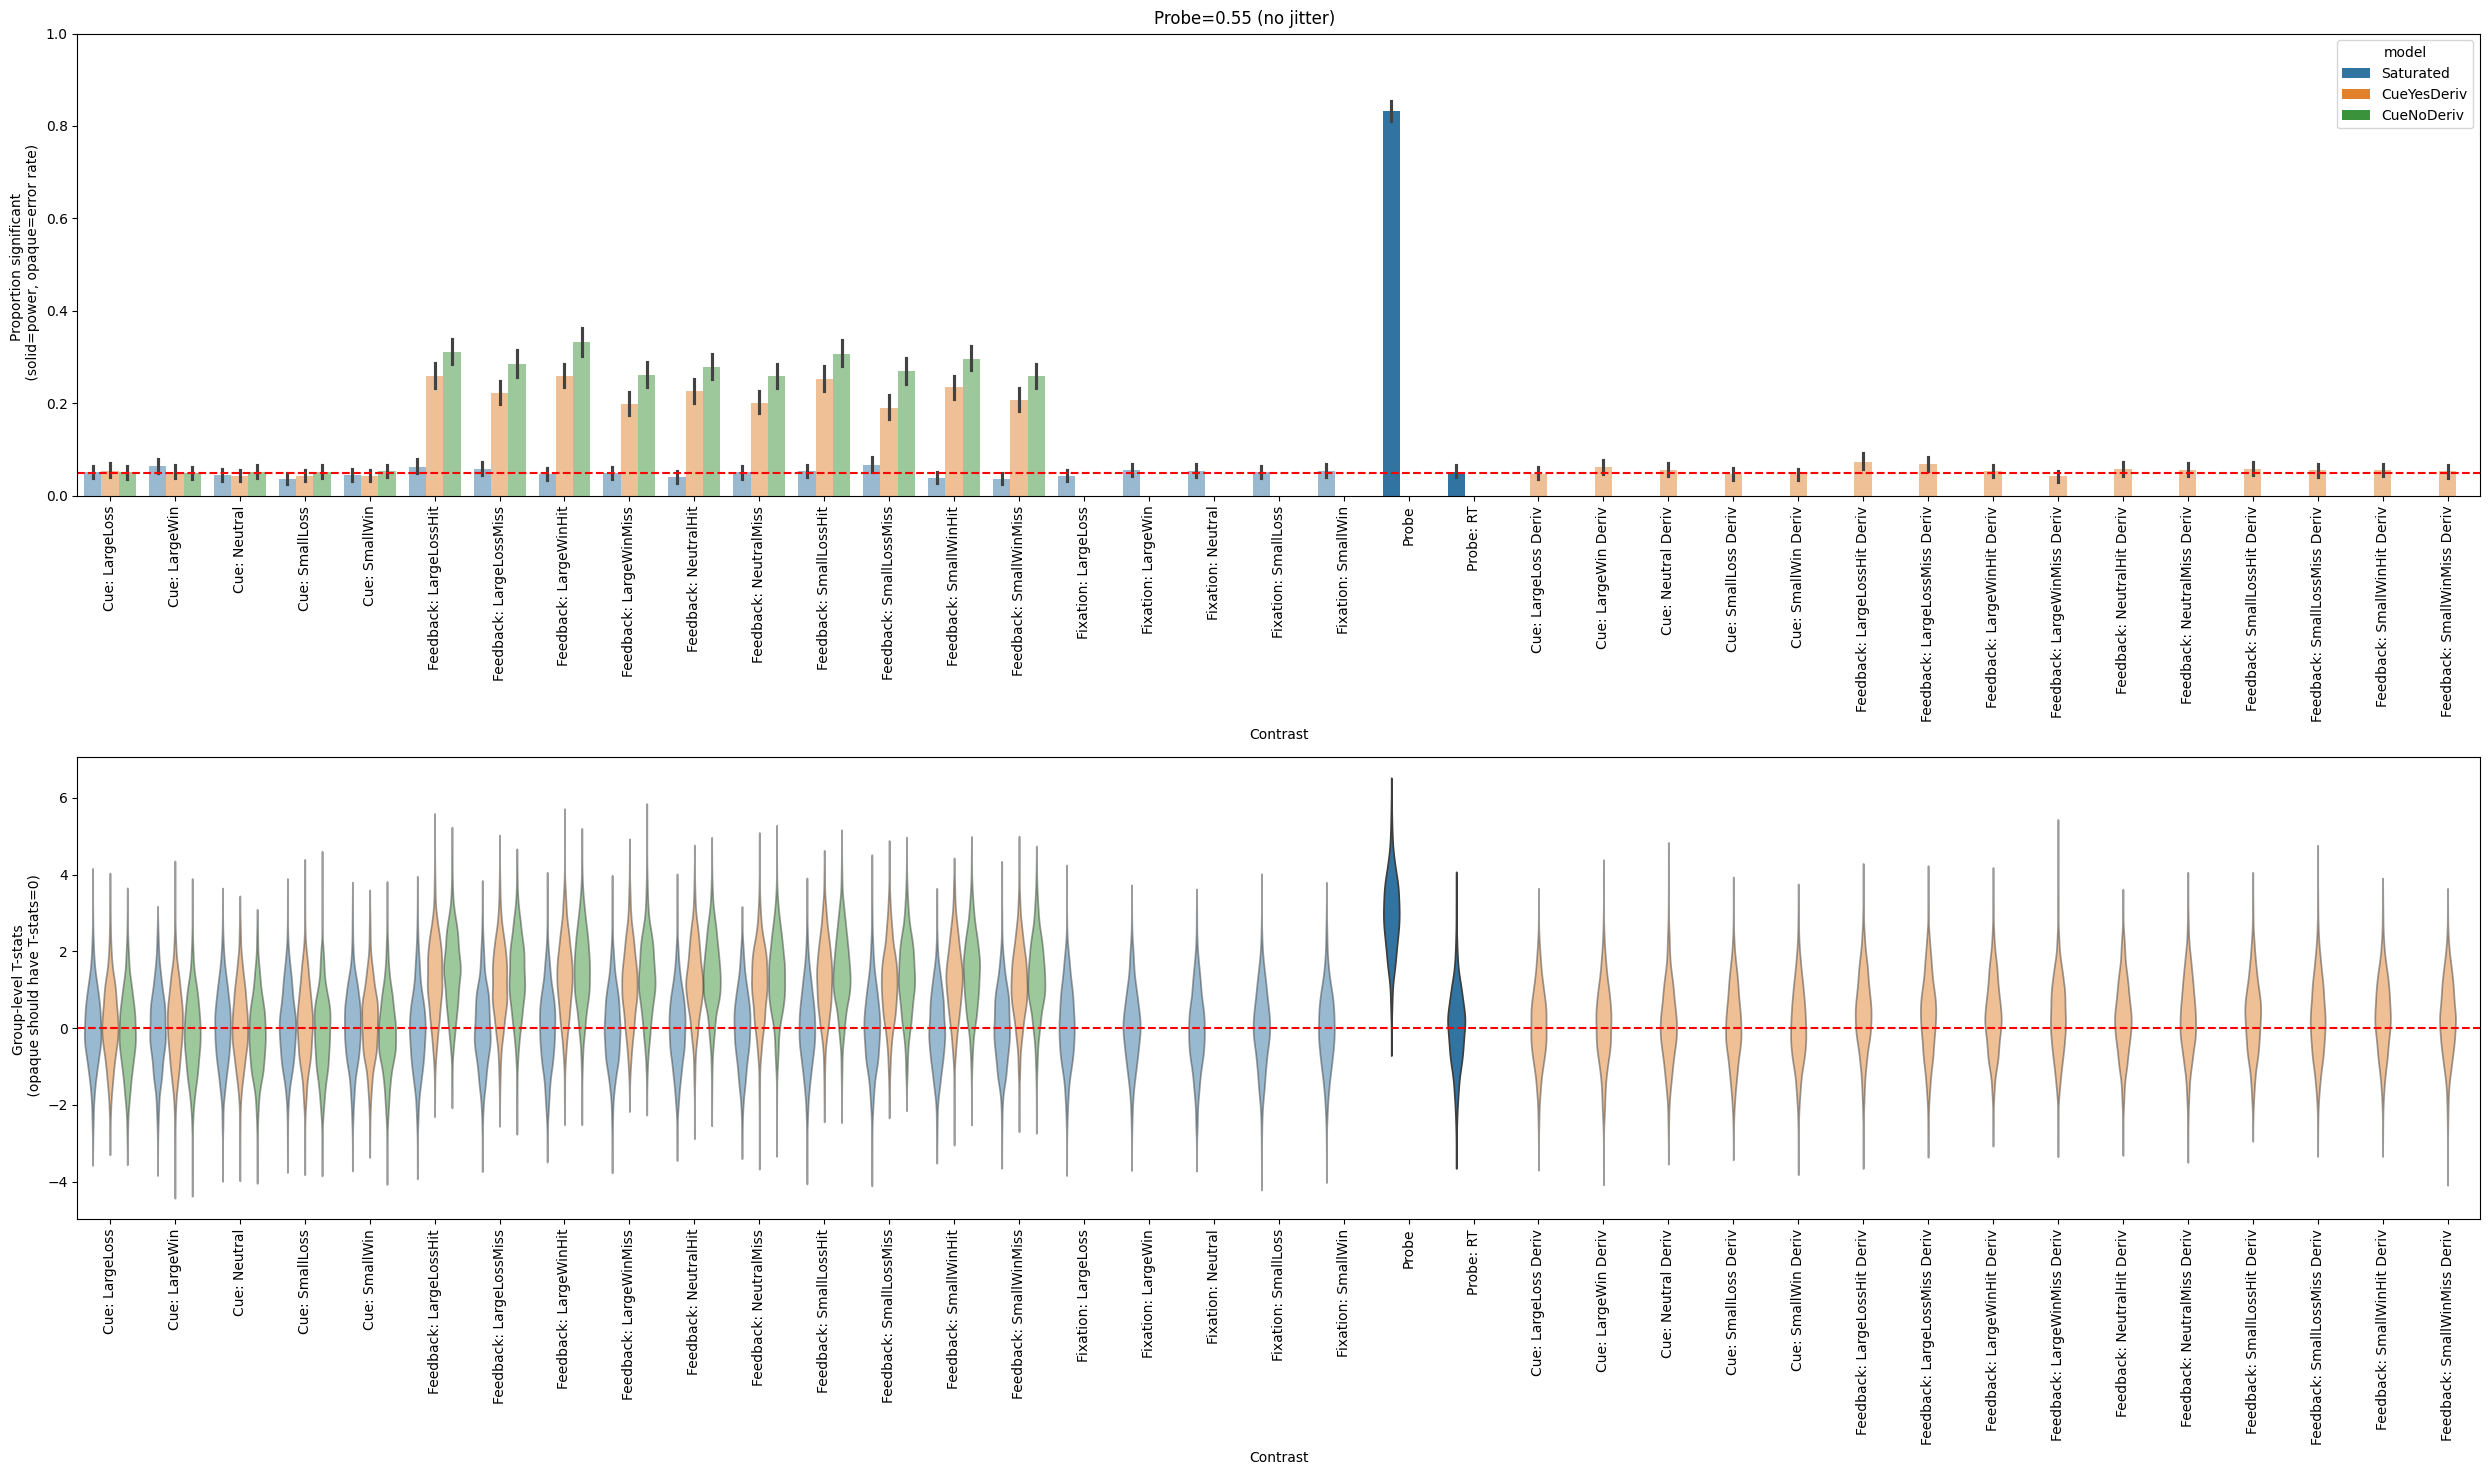

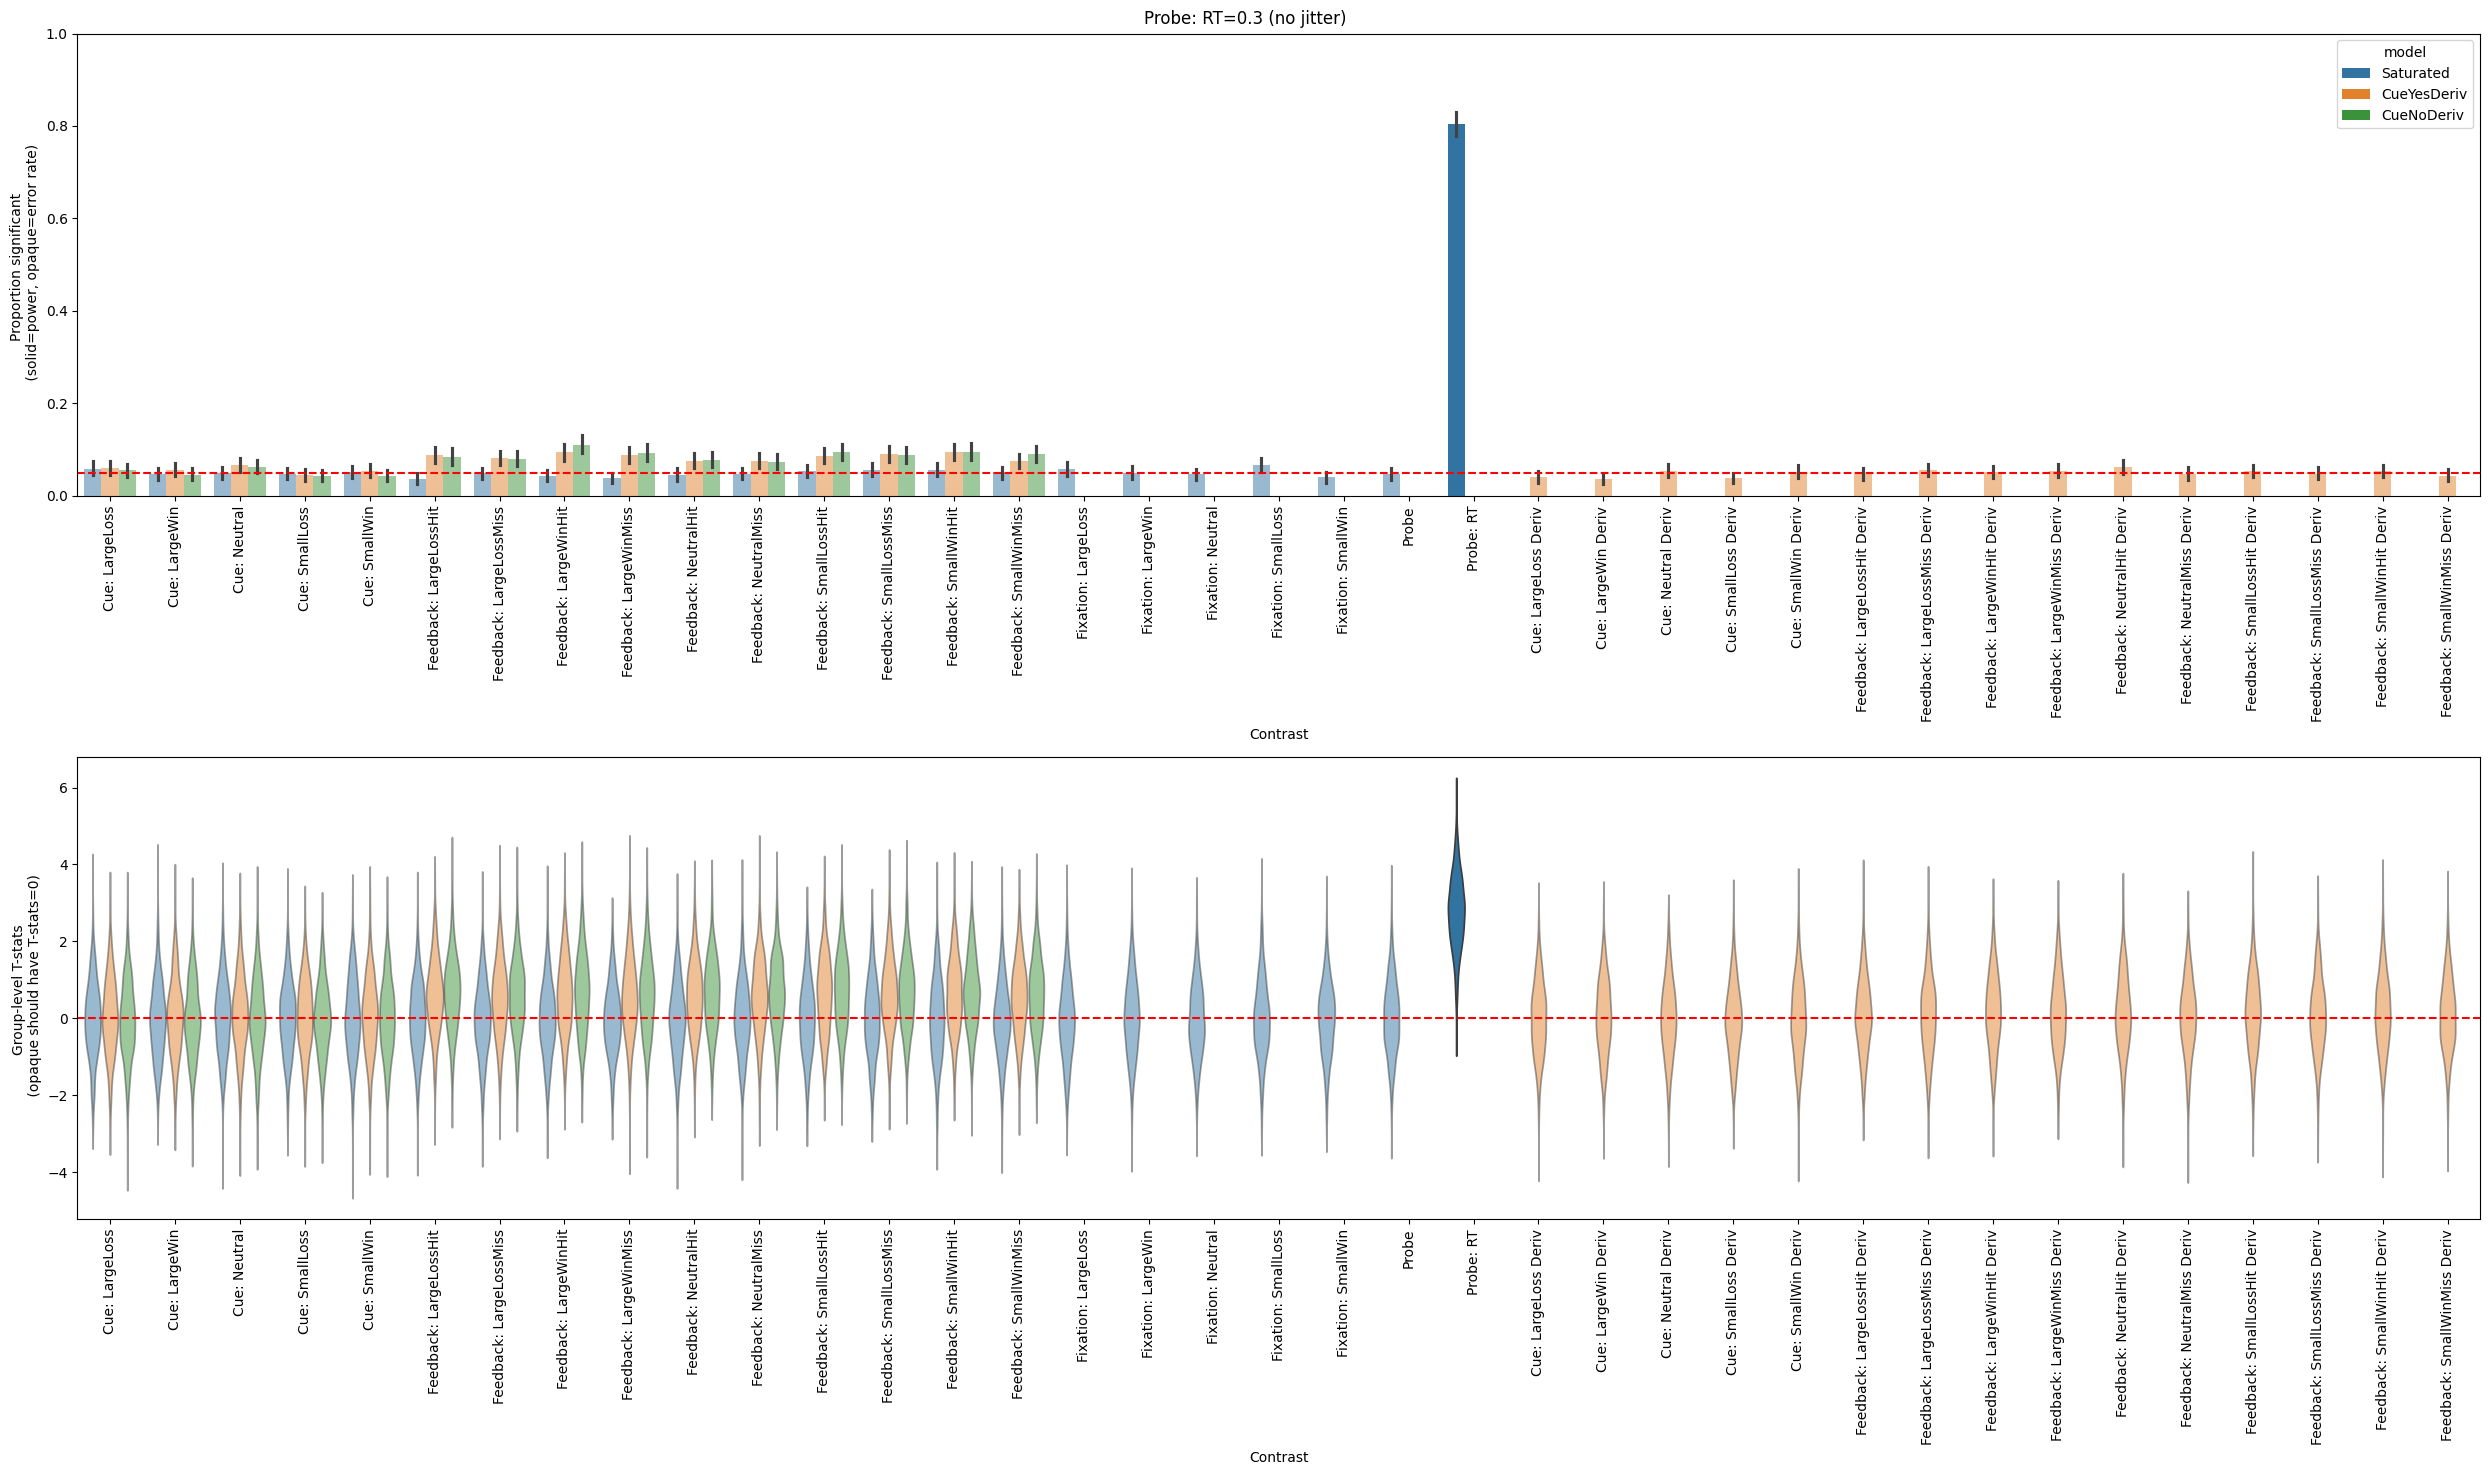

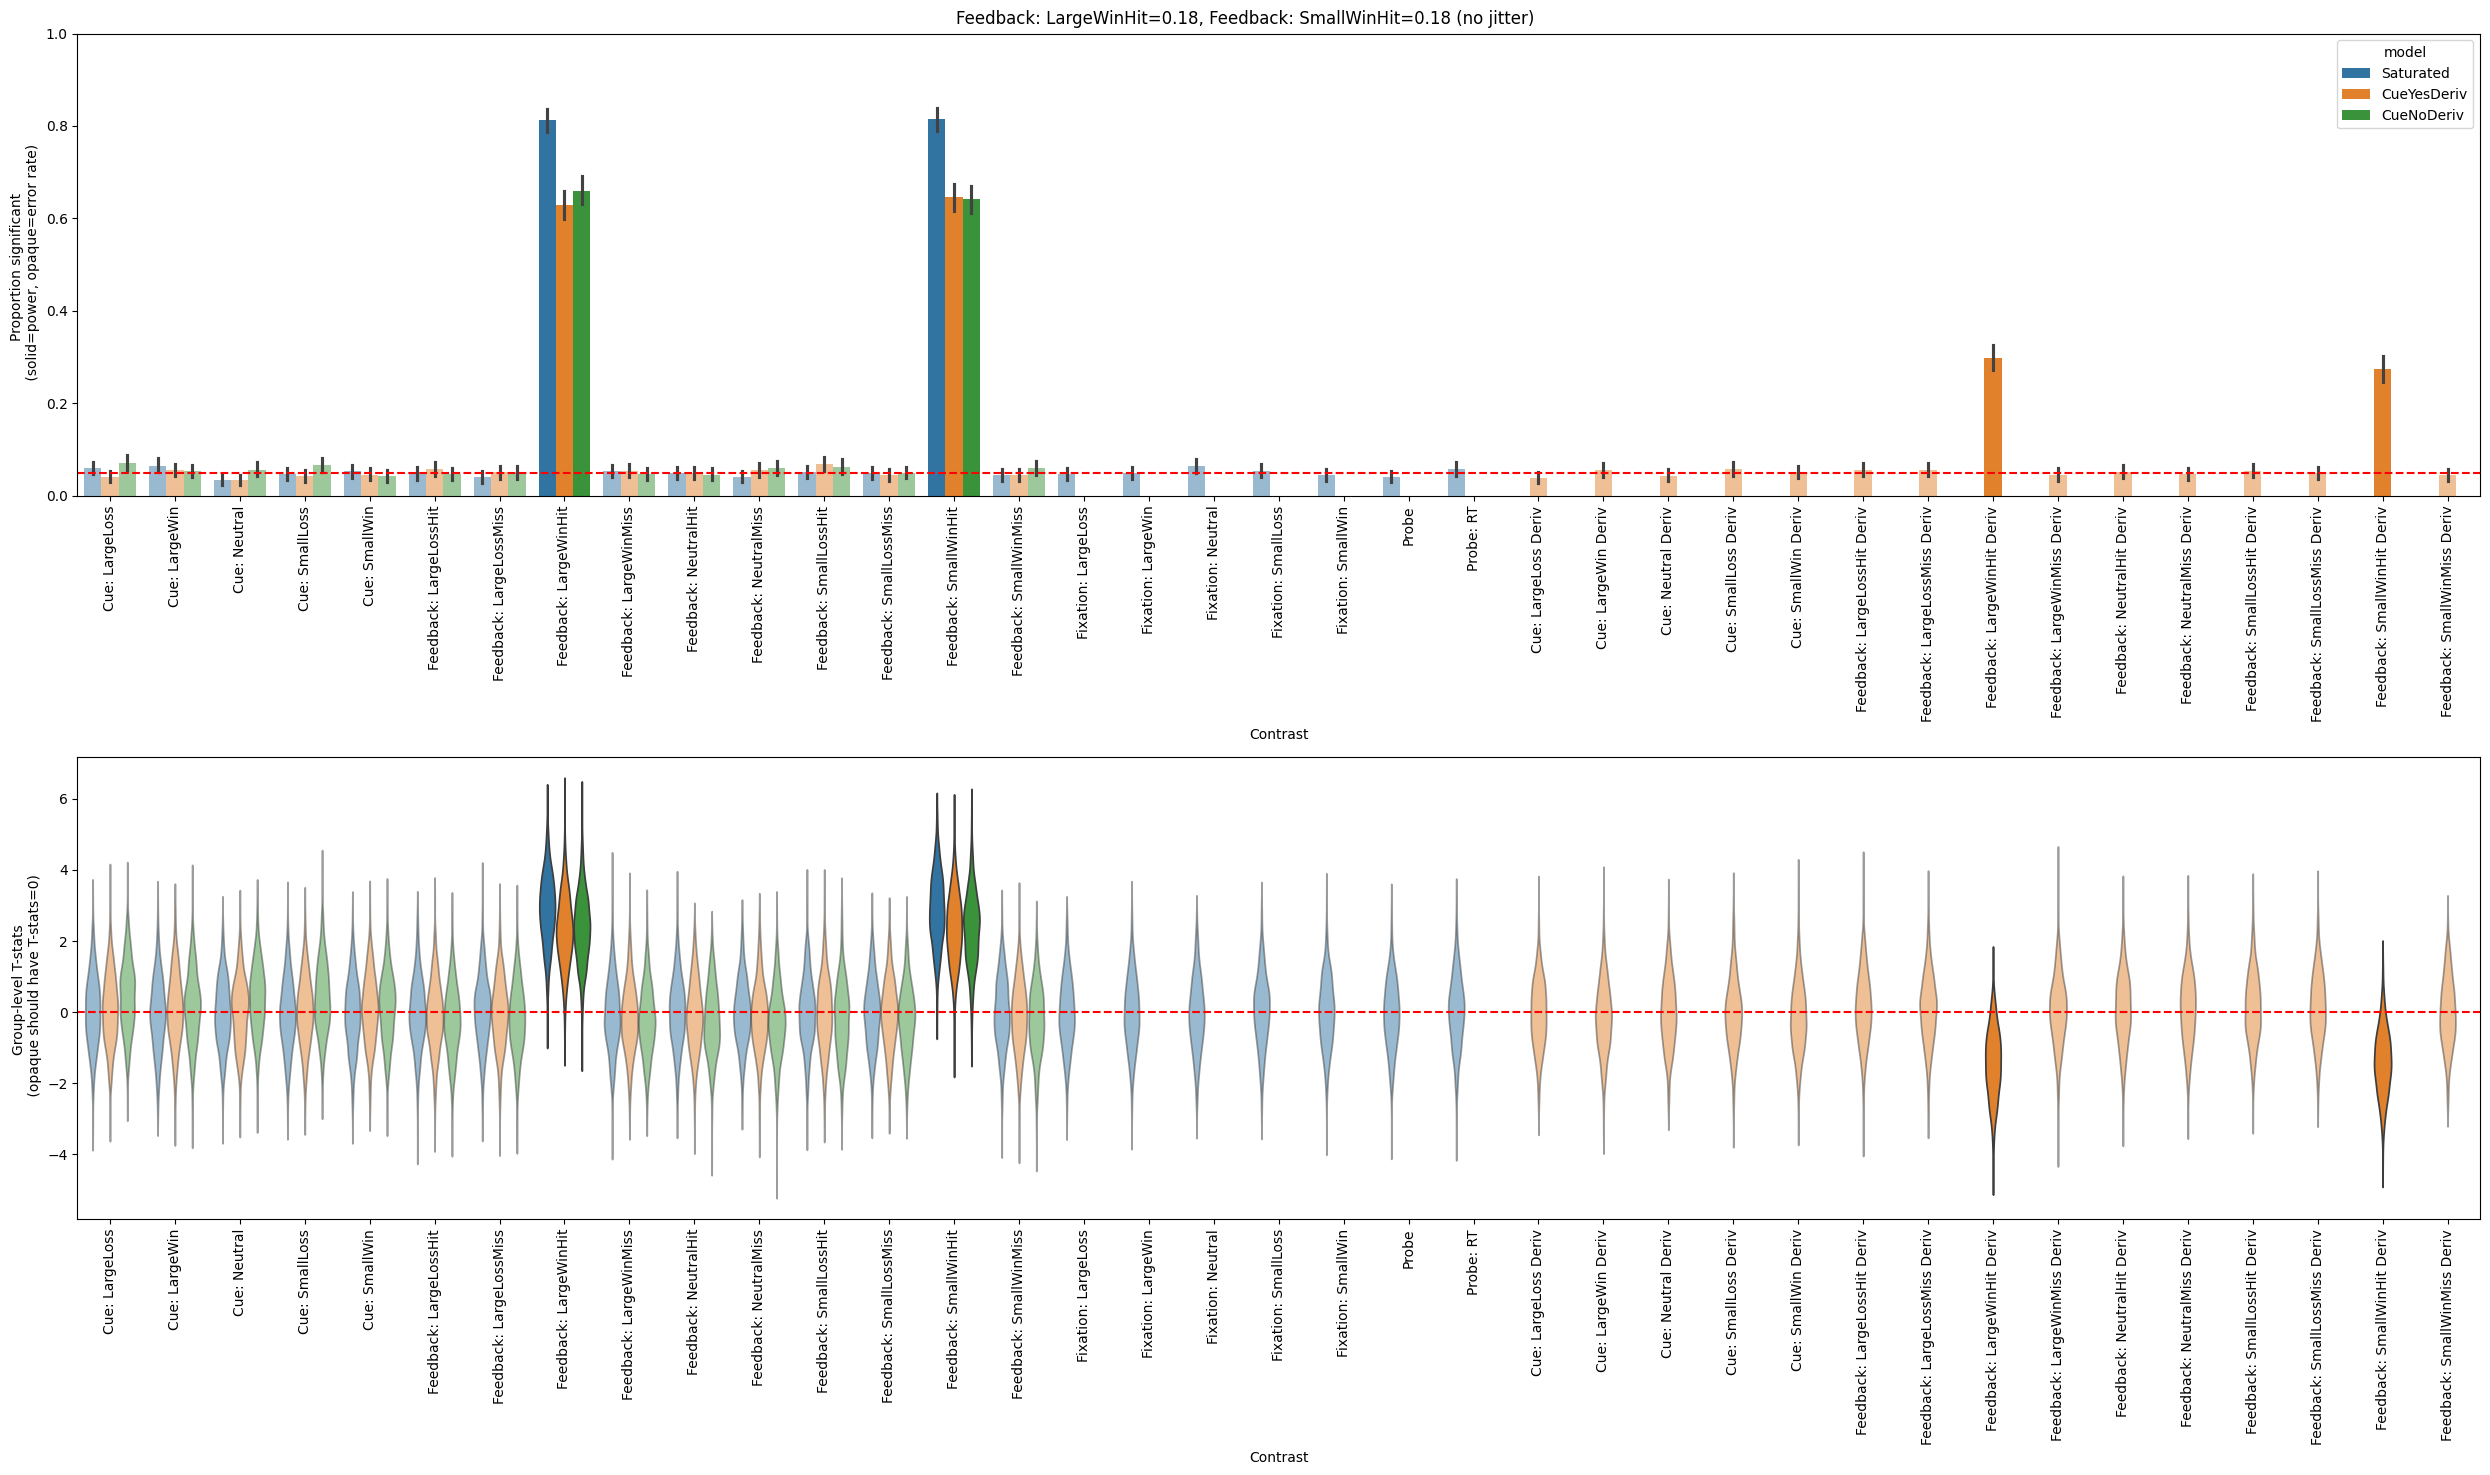

In [8]:
for name, result in results.items():
    result_loop = result[~result['contrast'].str.contains('-|Derivative')].copy()
    plot_results(result_loop, f'{name} (no jitter)', stacked=True)

### Bias and error rate grids used in mansucript and supplement

In [9]:
results_trimmed = results.copy()
omit_keys = [
    'Cue: LargeWin=0.15, Cue: SmallWin=0.15, Fixation: LargeWin=0.15, Fixation: SmallWin=0.15',
    'Cue: LargeWin=0.15, Cue: SmallWin=0.15, Fixation: LargeWin=0.15, Fixation: SmallWin=0.15, Probe=0.5, Probe: RT=0.3',
    'Feedback: LargeWinHit=0.09, Feedback: LargeWinMiss=-0.09',
]
for key in omit_keys:
    if key in results_trimmed.keys():
        results_trimmed.pop(key)

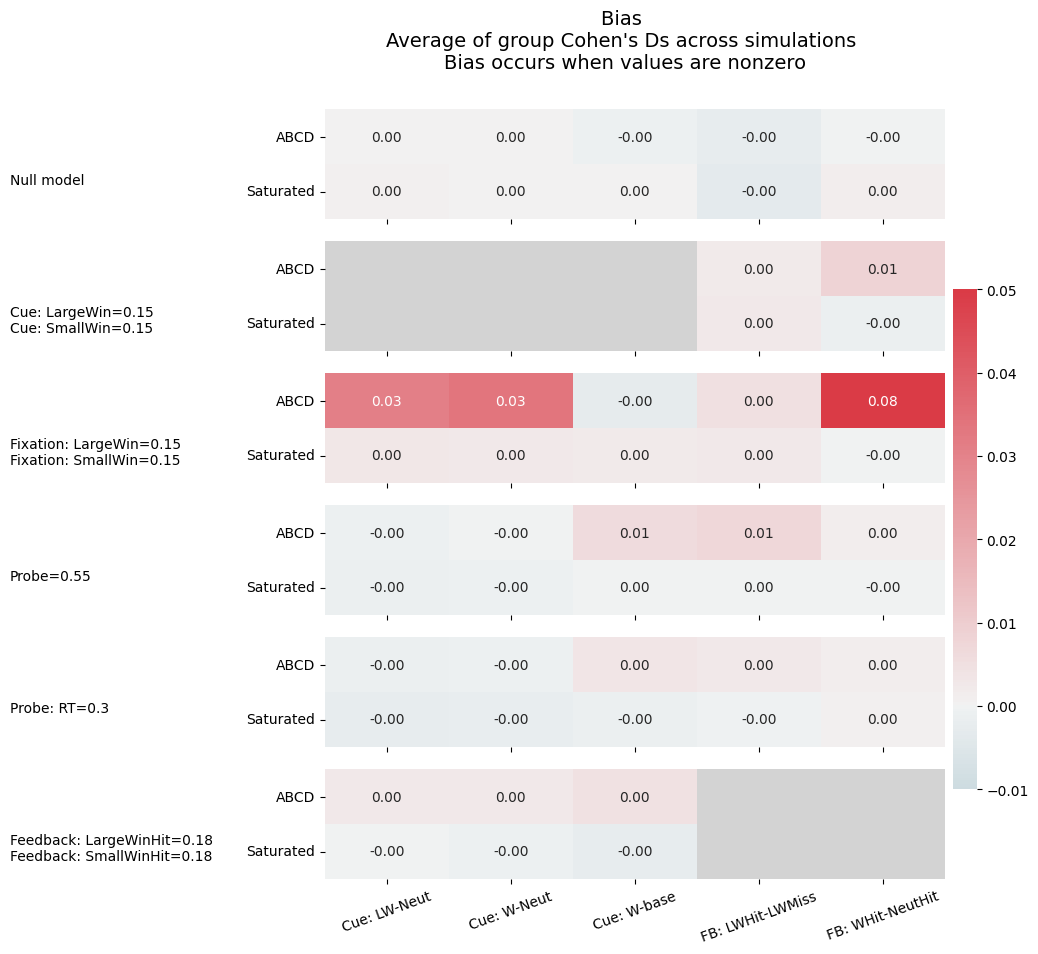

In [10]:
fig_path = f'{figure_output_path}/bias_grid_no_jitter.pdf'
plot_bias(
    results_trimmed,
    contrasts_only=True,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='ABCD',
)

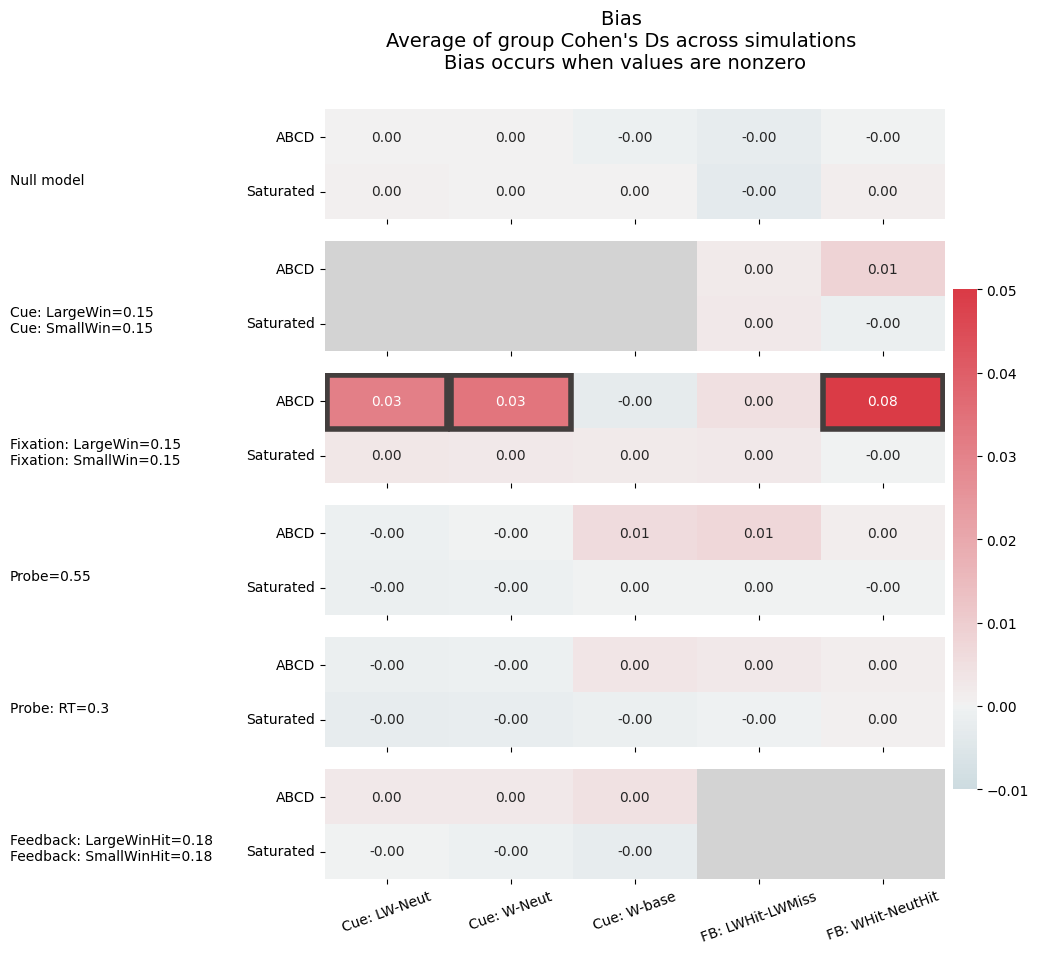

In [11]:
fig_path = f'{figure_output_path}/bias_grid_no_jitter_sig.pdf'

plot_bias_significance(
    results_trimmed,
    contrasts_only=True,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='ABCD',
)

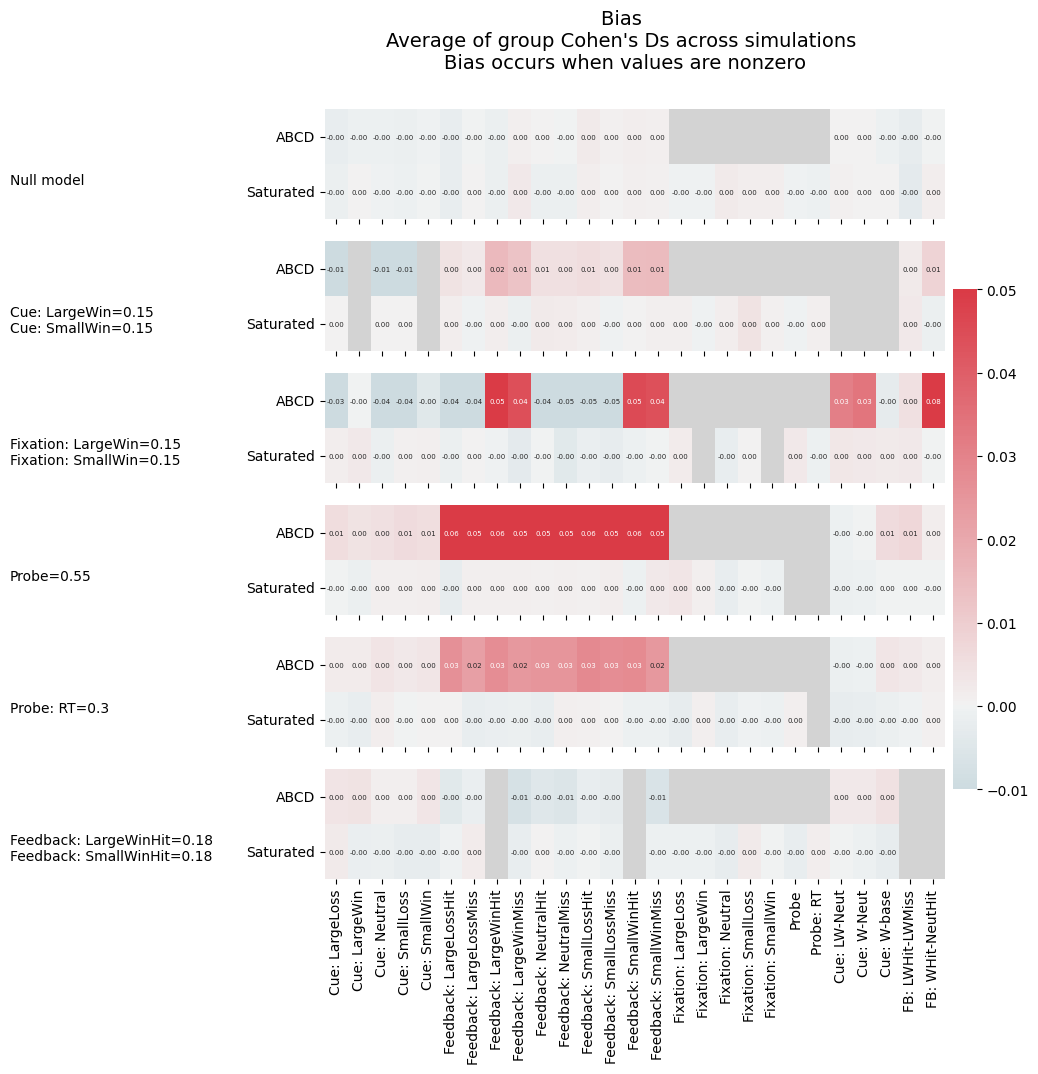

In [12]:
fig_path = f'{figure_output_path}/bias_grid_no_jitter_all.pdf'

plot_bias(
    results_trimmed,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='ABCD',
)

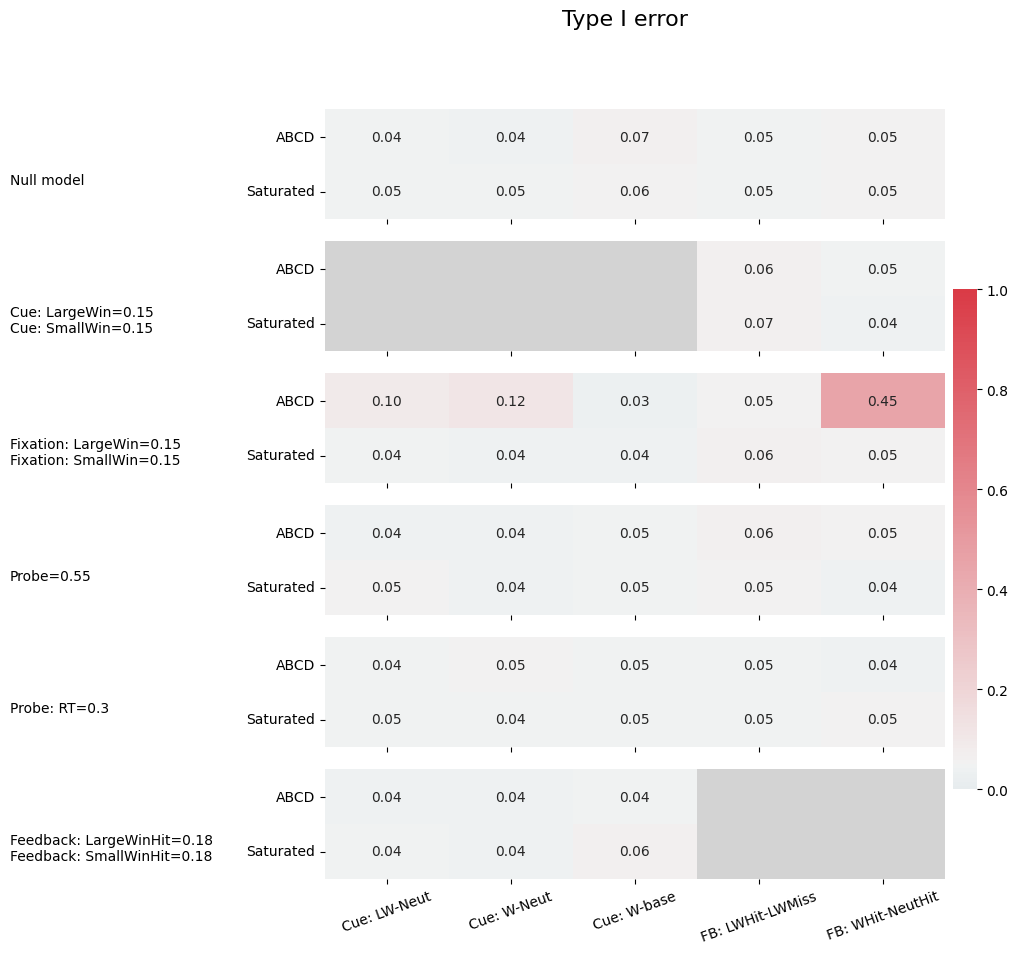

In [13]:
fig_path = f'{figure_output_path}/error_grid_no_jitter_contrasts.pdf'

plot_error_grid(
    results_trimmed,
    contrasts_only=True,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='ABCD',
)

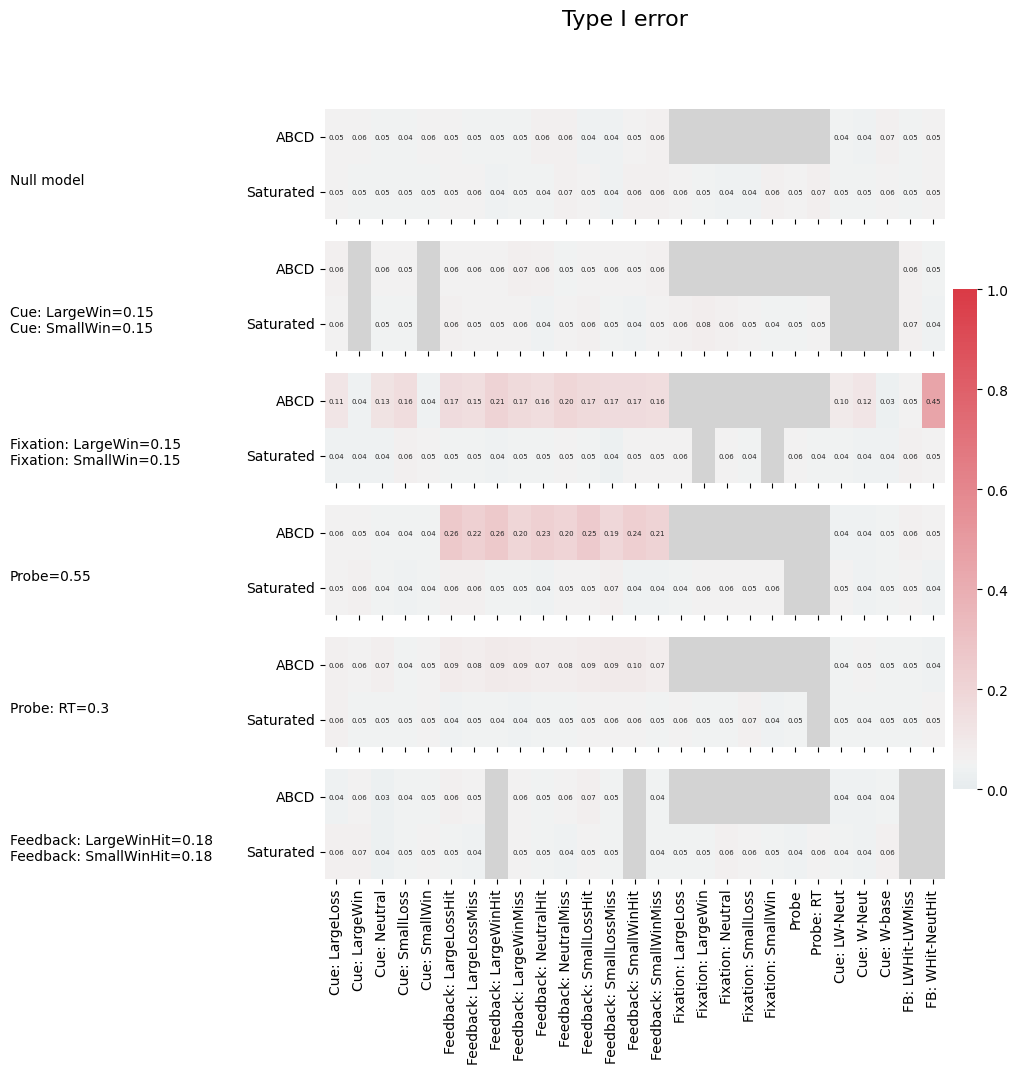

In [14]:
fig_path = f'{figure_output_path}/error_grid_no_jitter_all.pdf'

plot_error_grid(
    results_trimmed,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='ABCD',
)

## Repeat, but add a jittered ITI


In [15]:
beta_sub_sd = 1
noise_sd = 1
nsims = 1000

results_jitter = {}

for beta_dict in beta_dicts:
    print(beta_dict)
    figure_label = make_analysis_label(beta_dict)
    (
        results_jitter[figure_label],
        _,
        desmat_example_jitter,
    ) = sim_group_models_parallel(
        beta_dict,
        noise_sd,
        beta_sub_sd,
        nsims=nsims,
        oversampling=5,
        tr=1,
        jitter=True,
        jitter_iti_min=2,
        jitter_iti_max=5,
        dataset=dataset,
    )

{}
{'Cue: LargeWin': 0.15, 'Cue: SmallWin': 0.15}
{'Fixation: LargeWin': 0.15, 'Fixation: SmallWin': 0.15}
{'Probe': 0.55}
{'Probe: RT': 0.3}
{'Feedback: LargeWinHit': 0.18, 'Feedback: SmallWinHit': 0.18}


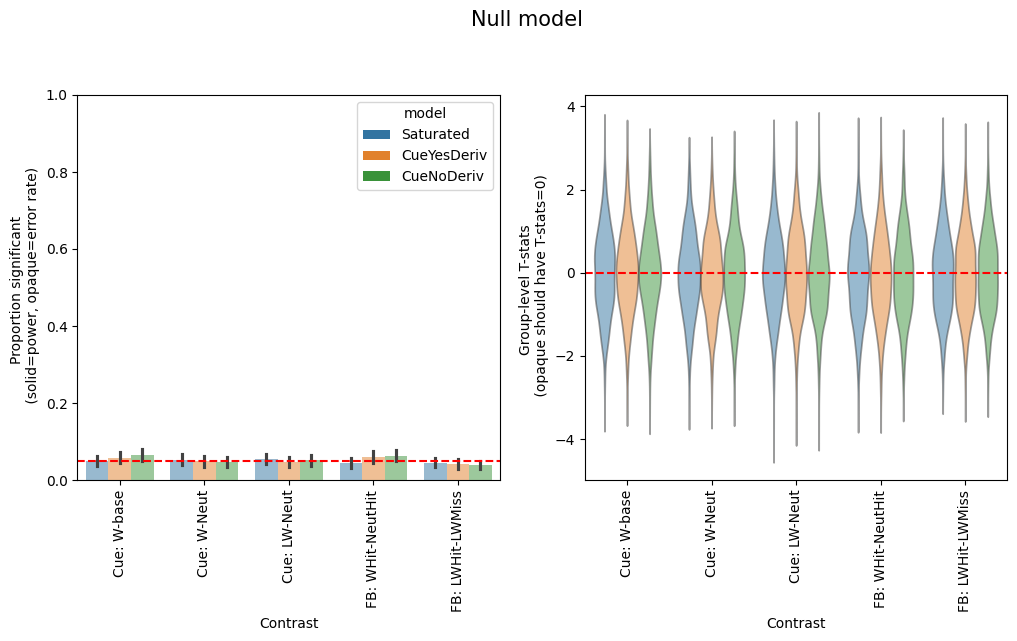

In [16]:
plot_dict_of_results({'Null model': results_jitter['Null model']}, contrasts=True)

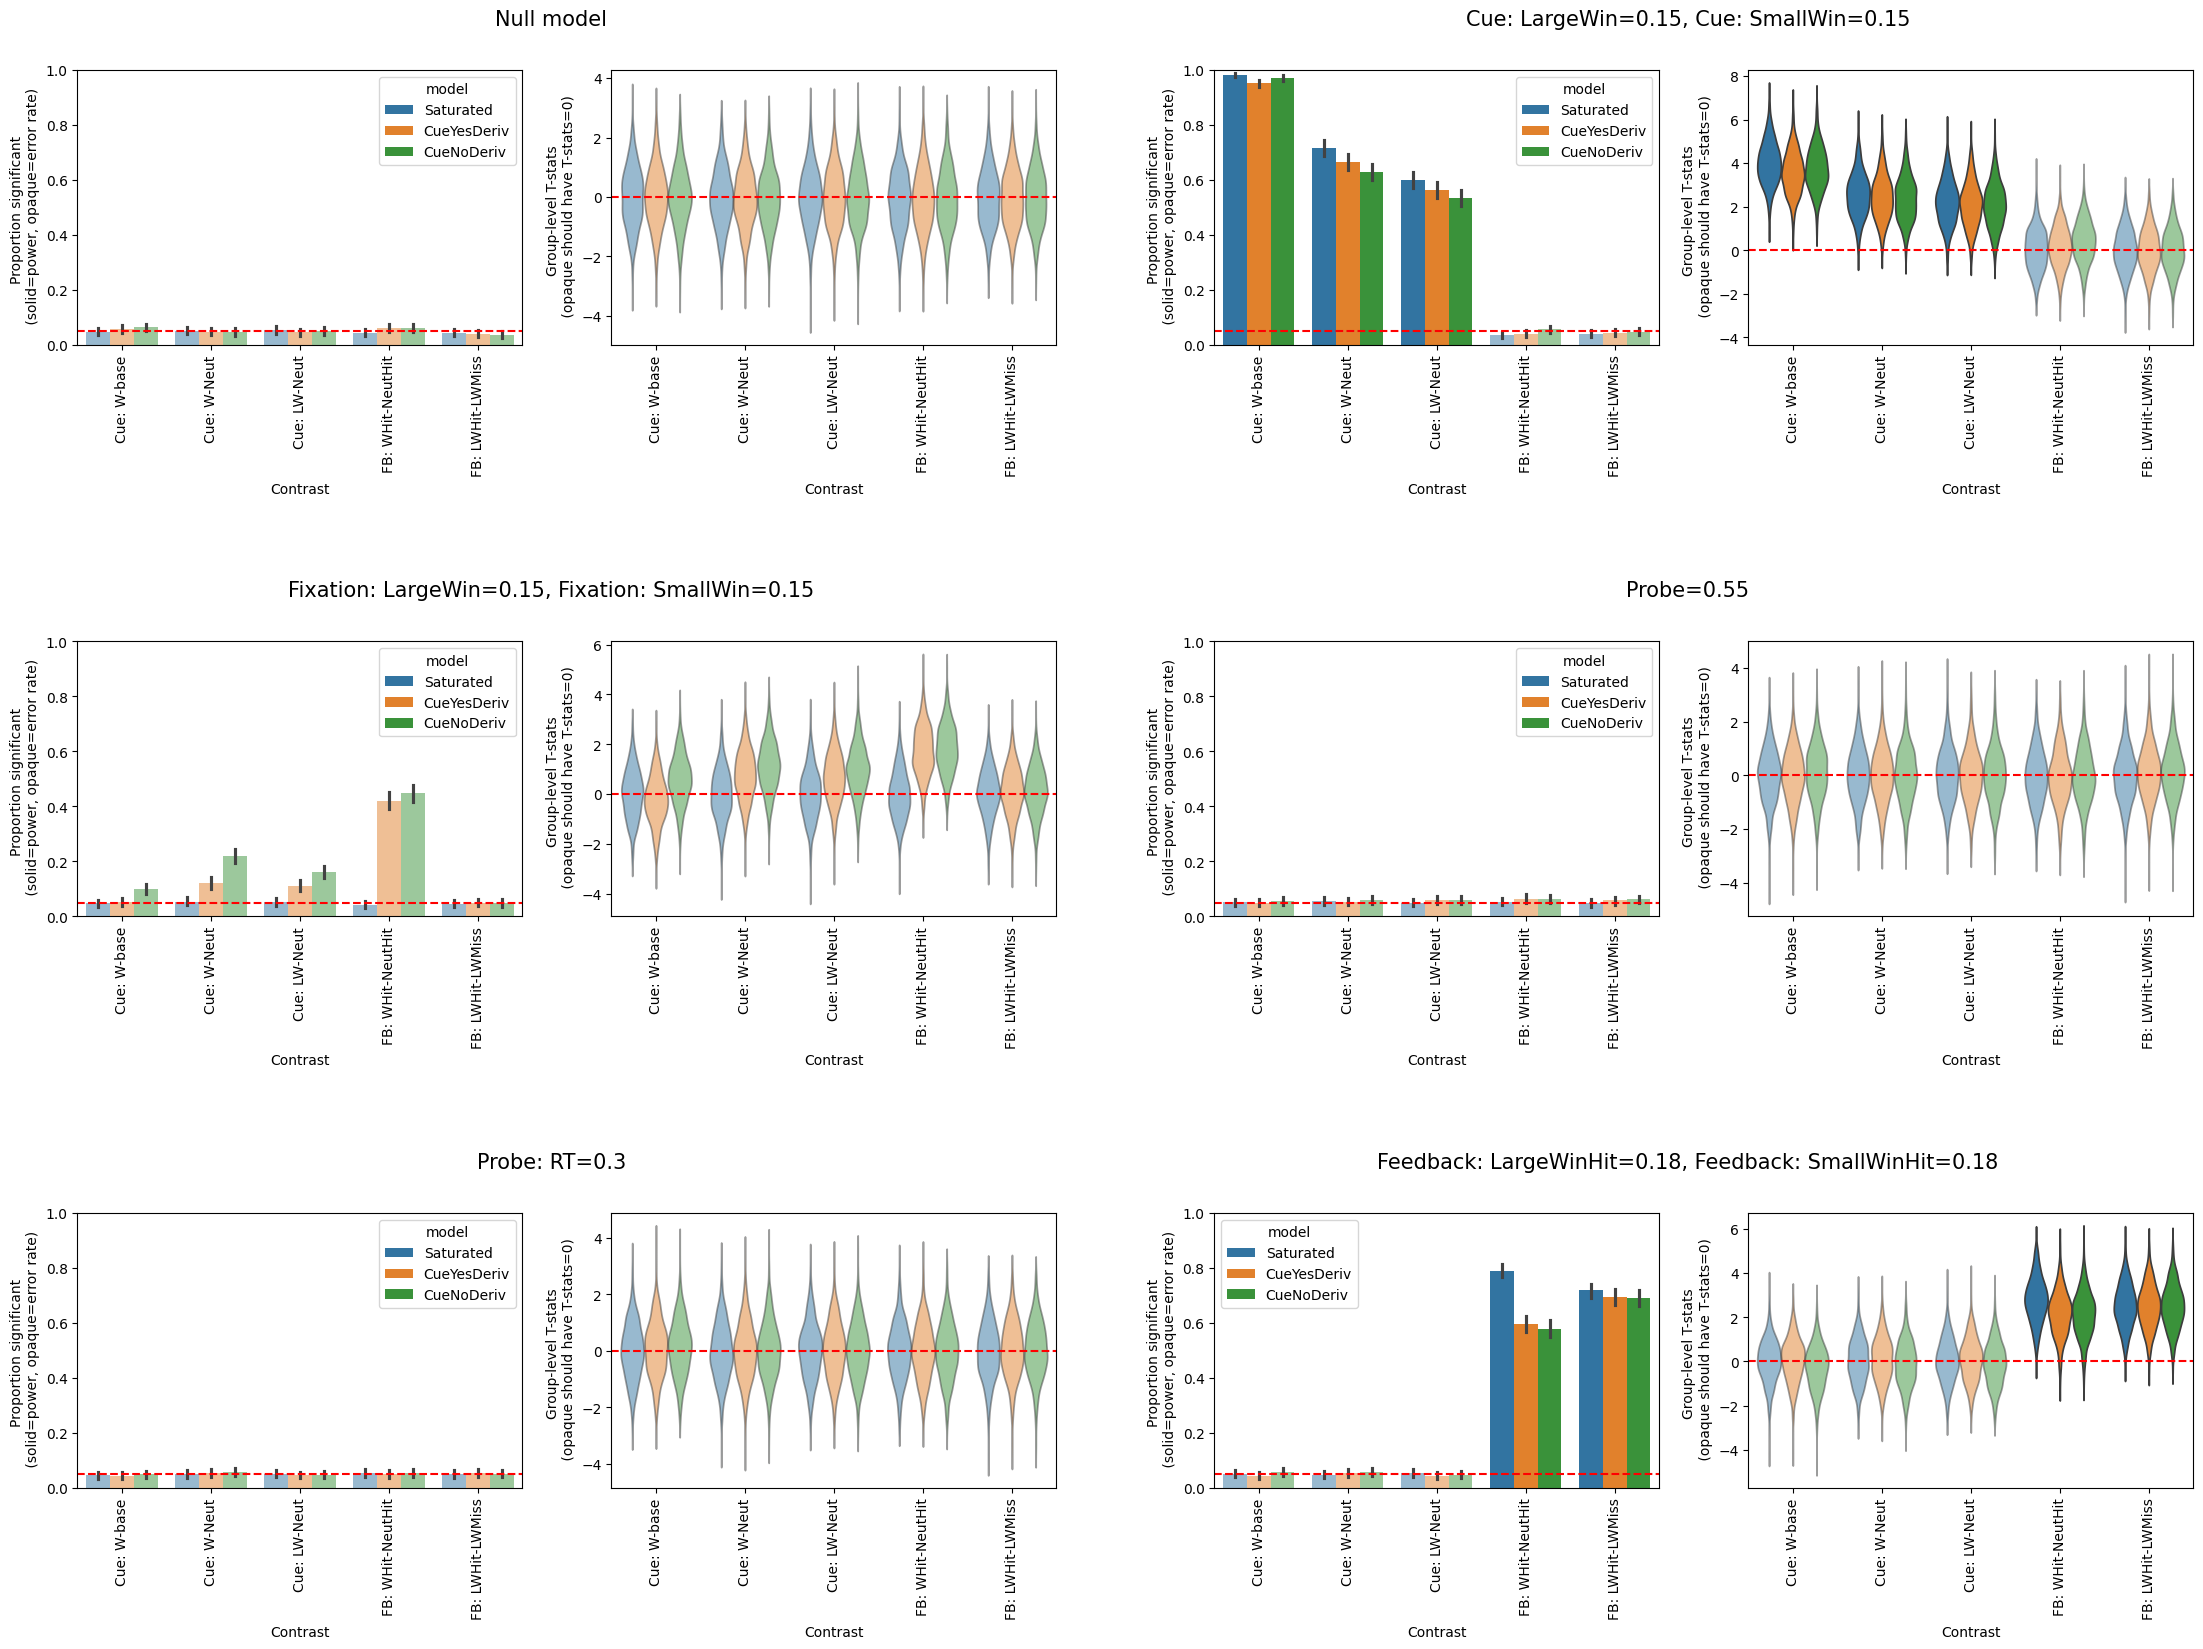

In [17]:
results_jitter_plot = results_jitter.copy()
if len(results_jitter_plot) % 2 != 0:
    results_jitter_plot.pop('Null model')
plot_dict_of_results(results_jitter_plot, contrasts=True)

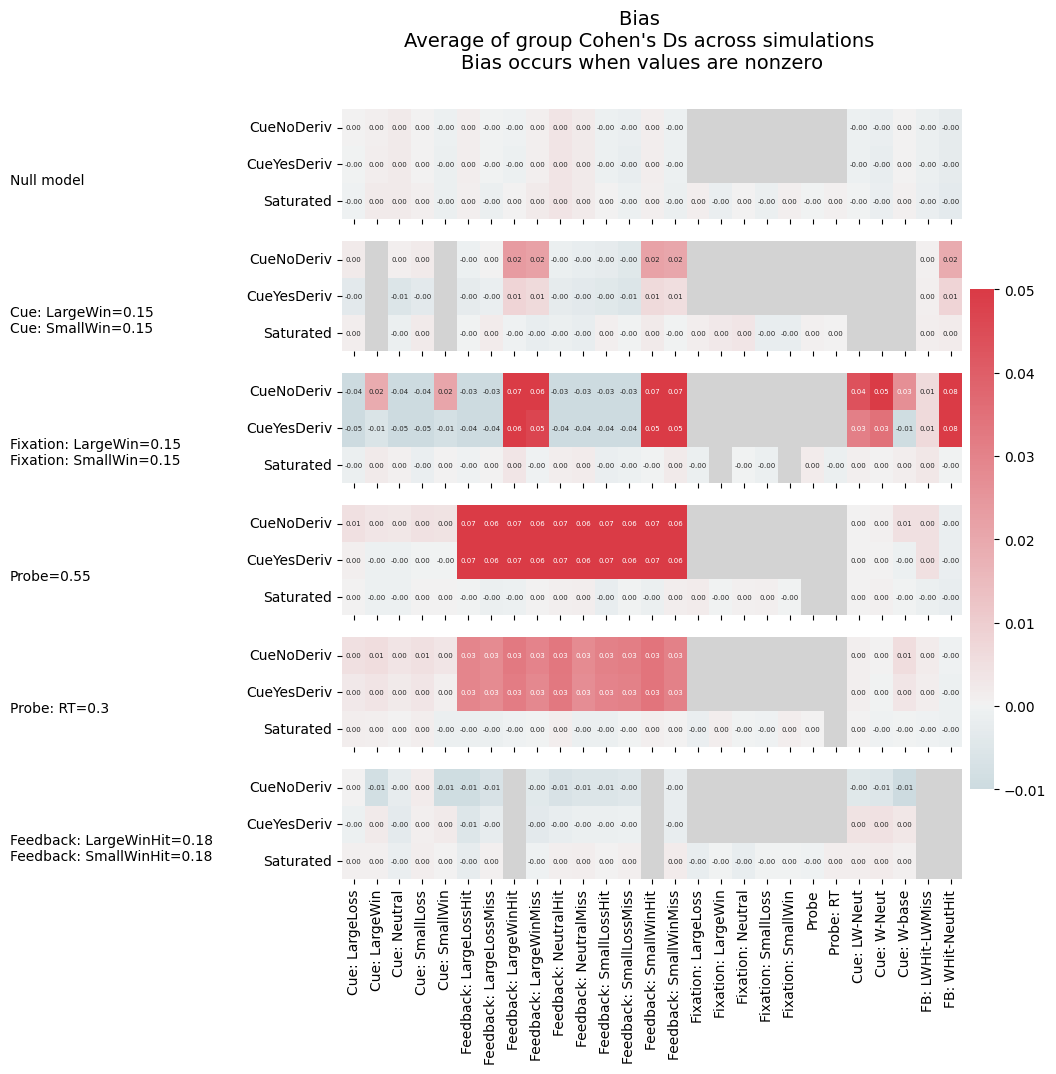

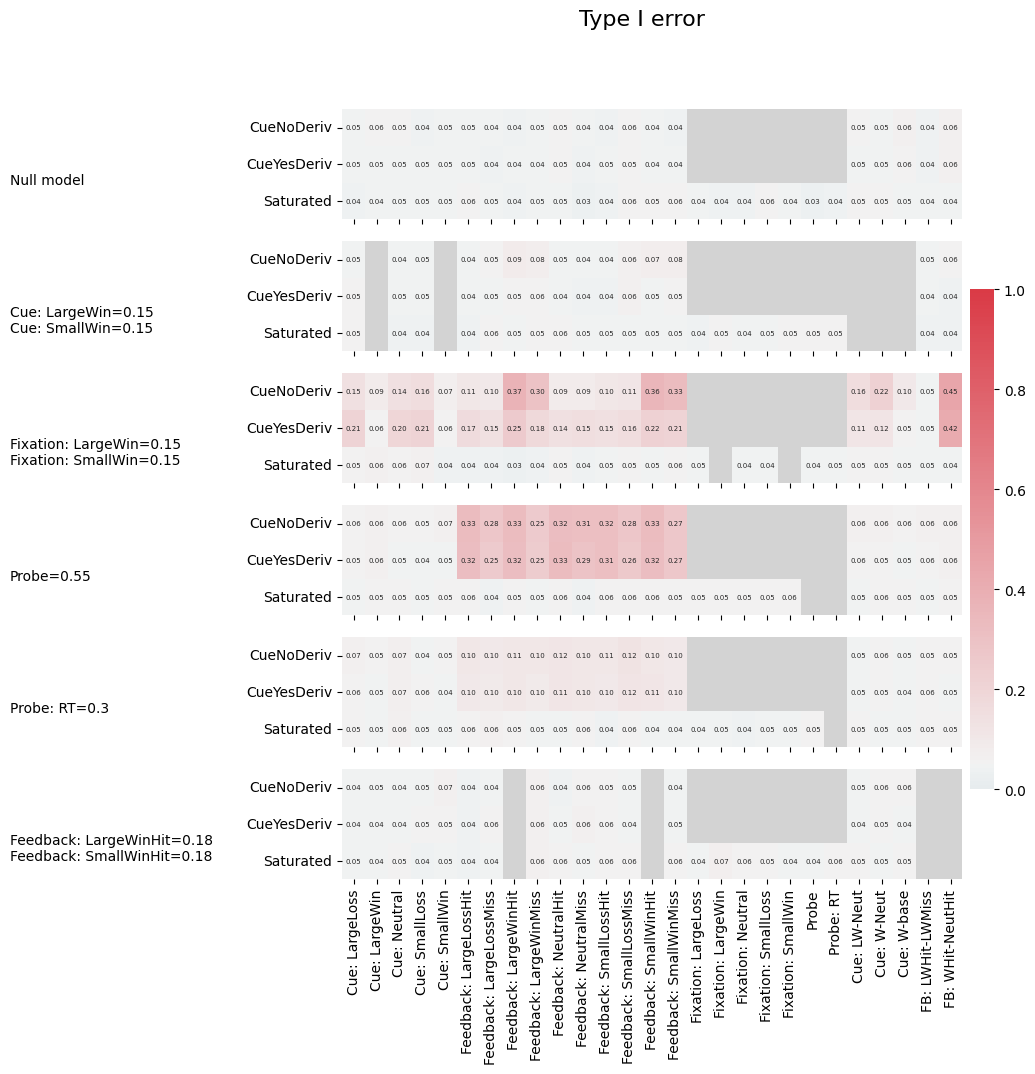

In [18]:
plot_bias(results_jitter)

plot_error_grid(results_jitter)

# VIFs/efficiency

In [4]:
vif_eff_no_jitter = est_eff_vif_all_subs(oversampling=50, tr=0.8, dataset=dataset)


In [5]:
# oversampling=50, tr=.8, previously 5 and 1
vif_eff_yes_jitter = est_eff_vif_all_subs(
    oversampling=50,
    tr=0.8,
    jitter=True,
    jitter_iti_min=2,
    jitter_iti_max=6,
    dataset=dataset,
)

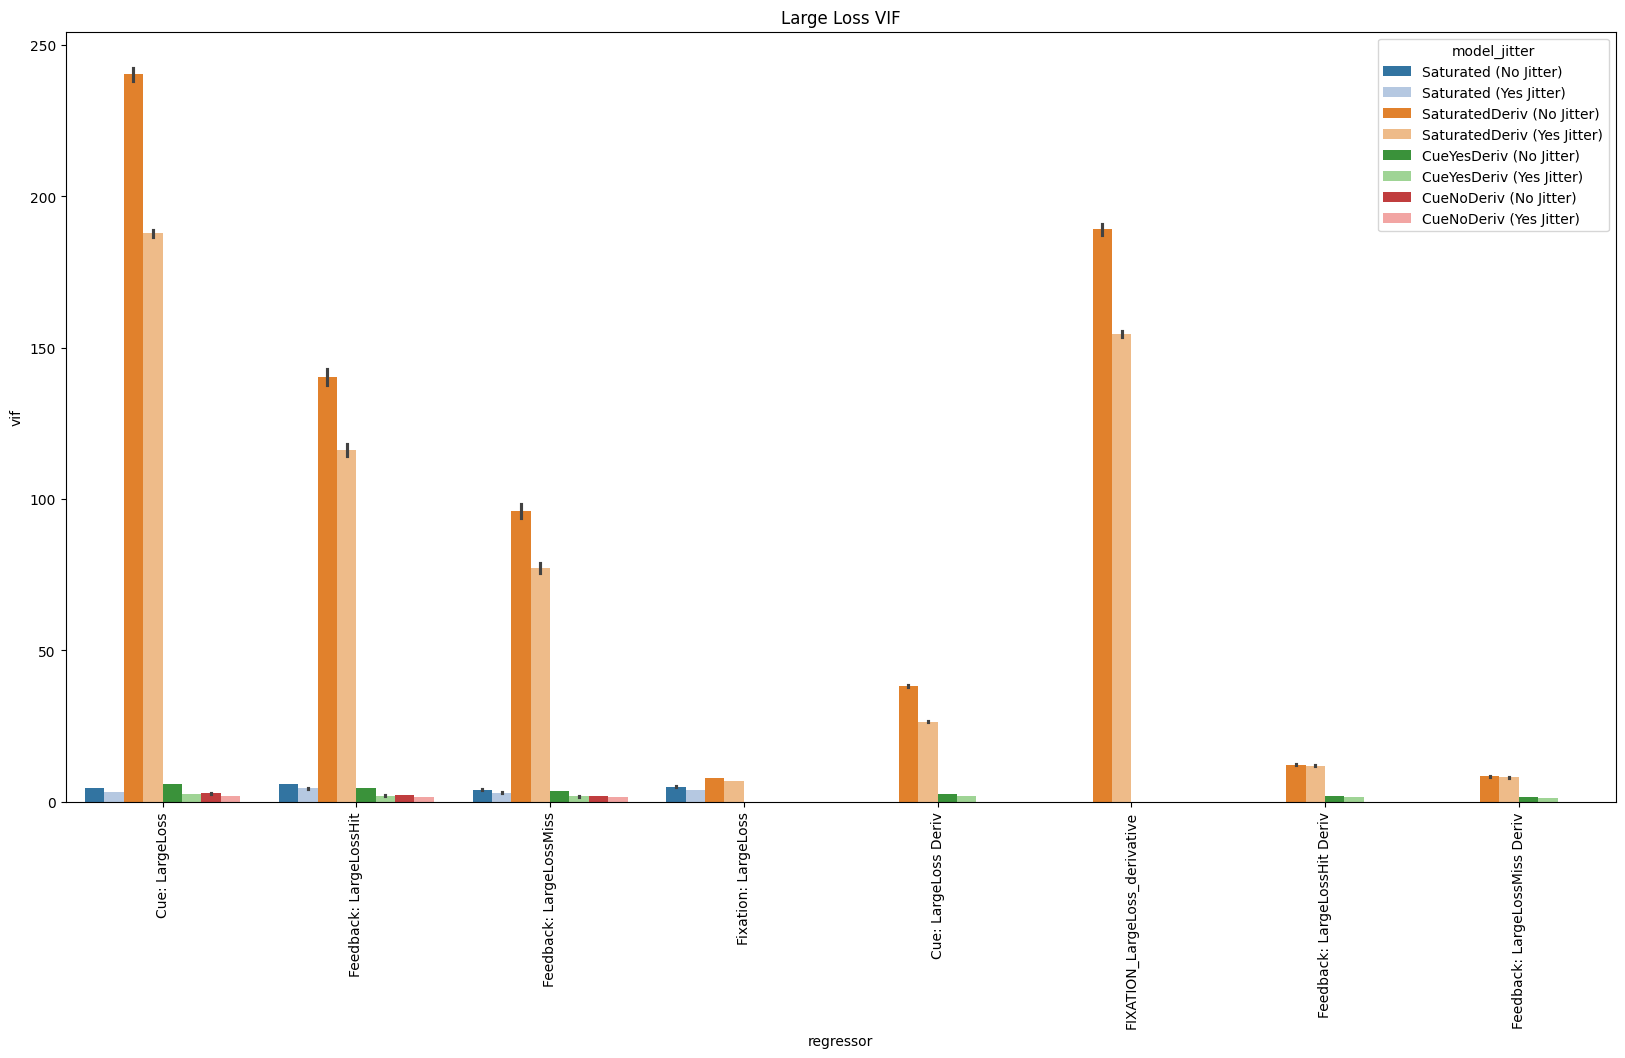

In [6]:
vif_eff_no_jitter['vifs']['Jitter'] = 'No Jitter'
vif_eff_yes_jitter['vifs']['Jitter'] = 'Yes Jitter'
vif_dat_plot = pd.concat([vif_eff_no_jitter['vifs'], vif_eff_yes_jitter['vifs']])

vif_dat_plot['model_jitter'] = (
    vif_dat_plot['model'] + ' (' + vif_dat_plot['Jitter'] + ')'
)
# sufficient to just look at LargeLoss
vif_dat_large_loss = vif_dat_plot[vif_dat_plot['regressor'].str.contains('LargeLoss')]
fig = plt.subplots(1, 1, figsize=(20, 10))
hue_order = [
    f'{model} {jitter_type}'
    for model in ['Saturated', 'SaturatedDeriv', 'CueYesDeriv', 'CueNoDeriv']
    for jitter_type in ['(No Jitter)', '(Yes Jitter)']
]
sns.barplot(
    data=vif_dat_large_loss,
    x='regressor',
    y='vif',
    hue='model_jitter',
    hue_order=hue_order,
    palette='tab20',
)
plt.tick_params(axis='x', rotation=90)
plt.title('Large Loss VIF')
plt.show()

1.9777022997413132
380.4430785099015
89.18882490687999


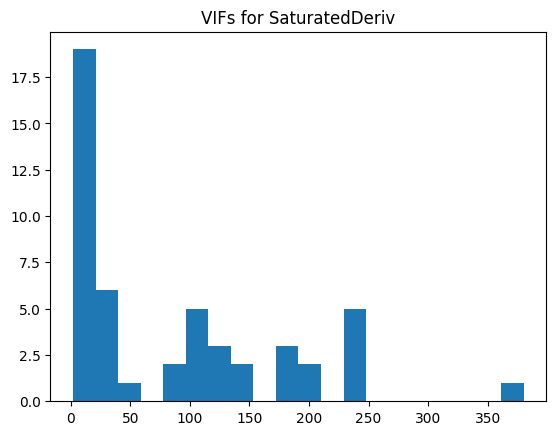

30
(49,)


In [7]:
vif_dat_plot
vif_avg_saturated_deriv = (
    vif_dat_plot[
        (vif_dat_plot['model'] == 'SaturatedDeriv')
        & (vif_dat_plot['Jitter'] == 'No Jitter')
    ]
    .groupby('regressor')['vif']
    .mean()
)
print(vif_avg_saturated_deriv.min())
print(vif_avg_saturated_deriv.max())
print(vif_avg_saturated_deriv.mean())


plt.hist(vif_avg_saturated_deriv, 20)
plt.title('VIFs for SaturatedDeriv')
plt.show()

print(np.sum(vif_avg_saturated_deriv > 20))
print(vif_avg_saturated_deriv.shape)

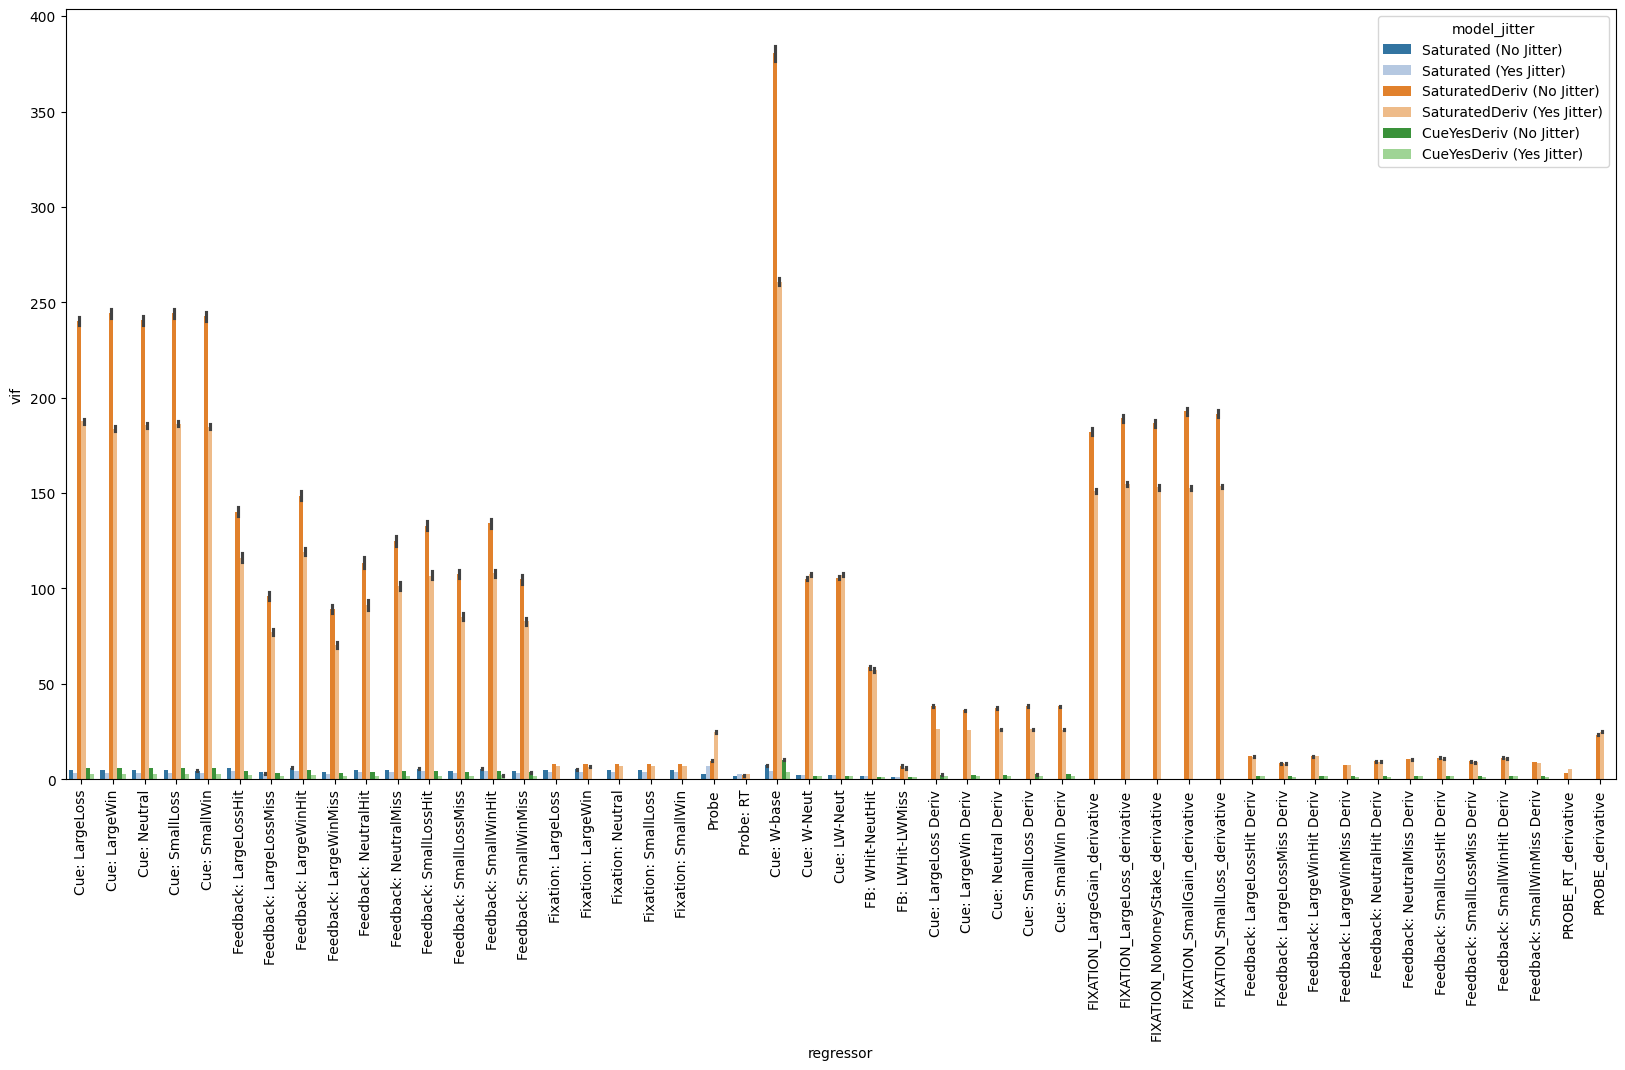

In [8]:
# Too messy with everything?
vif_trimmed = vif_dat_plot[
    ~vif_dat_plot['regressor'].str.contains('Derivative|constant')
]
vif_trimmed = vif_trimmed[~vif_trimmed['model'].str.contains('CueNoDeriv')]
fig = plt.subplots(1, 1, figsize=(20, 10))
hue_order = [
    f'{model} {jitter_type}'
    for model in ['Saturated', 'SaturatedDeriv', 'CueYesDeriv']
    for jitter_type in ['(No Jitter)', '(Yes Jitter)']
]
sns.barplot(
    data=vif_trimmed,
    x='regressor',
    y='vif',
    hue='model_jitter',
    hue_order=hue_order,
    palette='tab20',
)
plt.tick_params(axis='x', rotation=90)
# plt.title('Large Loss VIF')
plt.show()

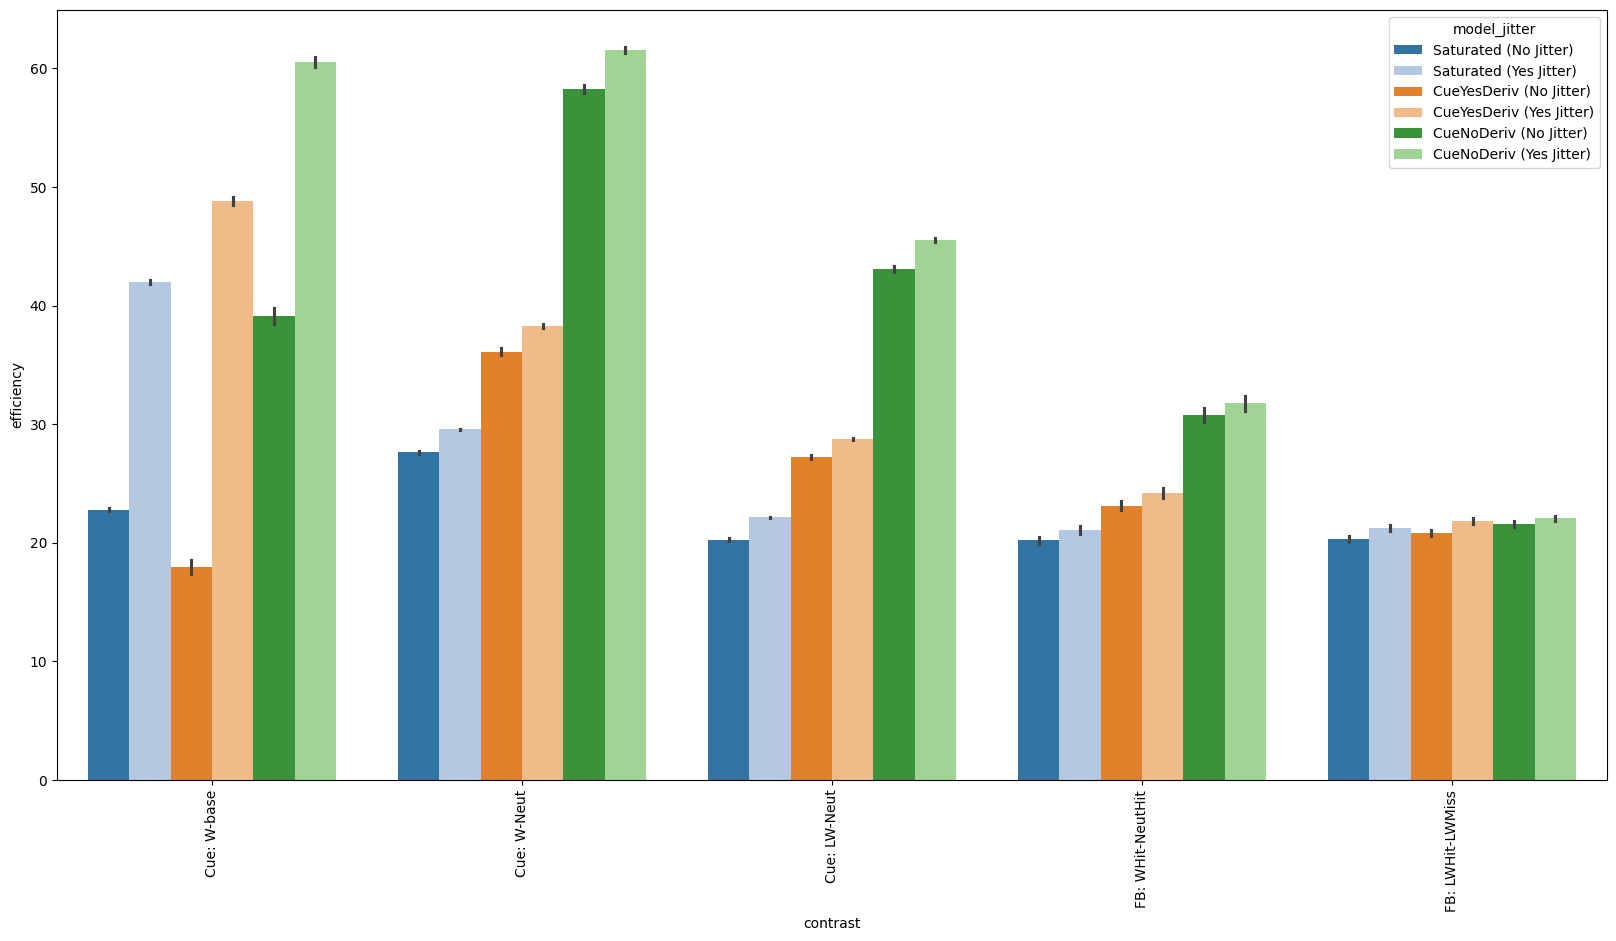

In [9]:
vif_eff_no_jitter['efficiencies']['Jitter'] = 'No Jitter'
vif_eff_yes_jitter['efficiencies']['Jitter'] = 'Yes Jitter'
eff_dat_plot = pd.concat(
    [vif_eff_no_jitter['efficiencies'], vif_eff_yes_jitter['efficiencies']]
)
eff_dat_plot['model_jitter'] = (
    eff_dat_plot['model'] + ' (' + eff_dat_plot['Jitter'] + ')'
)

eff_dat_no_cue_fix = eff_dat_plot
eff_dat_no_cue_fix_contrasts = eff_dat_no_cue_fix[
    eff_dat_no_cue_fix['contrast'].str.contains('-')
]

hue_order = [
    f'{model} {jitter_type}'
    for model in ['Saturated', 'CueYesDeriv', 'CueNoDeriv']
    for jitter_type in ['(No Jitter)', '(Yes Jitter)']
]

fig = plt.subplots(1, 1, figsize=(20, 10))
sns.barplot(
    data=eff_dat_no_cue_fix_contrasts,
    x='contrast',
    y='efficiency',
    hue='model_jitter',
    hue_order=hue_order,
    palette='tab20',
)
# plt.ylim(0,.01)
plt.tick_params(axis='x', rotation=90)
plt.show()

### Figures with the two models used in the manuscript

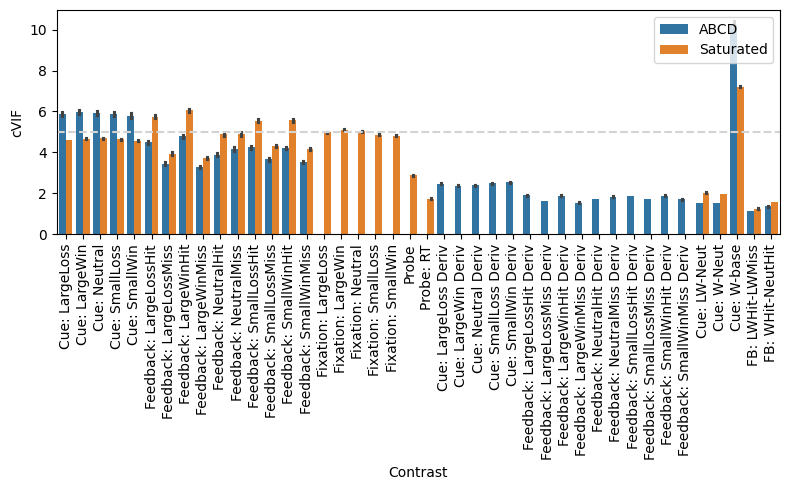

In [10]:
fig_path = f'{figure_output_path}/vif_barplot.pdf'

vif_trimmed = vif_dat_plot[
    ~vif_dat_plot['regressor'].str.contains('constant|derivative')
]
vif_trimmed = vif_trimmed[~vif_trimmed['model'].str.contains('CueNoDeriv')]
vif_trimmed = vif_trimmed[vif_trimmed['Jitter'] == 'No Jitter']
vif_trimmed['model'] = vif_trimmed['model'].str.replace('CueYesDeriv', 'ABCD')
vif_trimmed = vif_trimmed.rename(
    {'model': 'Model', 'vif': 'cVIF', 'regressor': 'Contrast'}, axis=1
)
# vif_trimmed_cue = vif_trimmed[vif_trimmed['Contrast'].str.contains('Cue') &  ~vif_trimmed['Contrast'].str.contains('-')]
# vif_trimmed_cue = vif_trimmed_cue.sort_values(by='Contrast')

# vif_trimmed_fix = vif_trimmed[vif_trimmed['Contrast'].str.contains('Fixation')]
# vif_trimmed_fix = vif_trimmed_fix.sort_values(by='Contrast')

# vif_trimmed_probe = vif_trimmed[vif_trimmed['Contrast'].str.contains('Probe')]
# vif_trimmed_probe = vif_trimmed_probe.sort_values(by='Contrast')

# vif_trimmed_feedback = vif_trimmed[vif_trimmed['Contrast'].str.contains('Feedback')]
# vif_trimmed_feedback = vif_trimmed_feedback.sort_values(by='Contrast')

vif_trimmed_not_cons = vif_trimmed[~vif_trimmed['Contrast'].str.contains('-')]

vif_trimmed_cons = vif_trimmed[vif_trimmed['Contrast'].str.contains('-')]
vif_trimmed_cons = vif_trimmed_cons.sort_values(by='Contrast')
vif_plot = pd.concat([vif_trimmed_not_cons, vif_trimmed_cons])
# vif_plot = pd.concat([vif_trimmed_cue, vif_trimmed_fix, vif_trimmed_probe, vif_trimmed_feedback, vif_trimmed_cons])

fig = plt.subplots(1, 1, figsize=(8, 5))
hue_order = [f'{model}' for model in ['ABCD', 'Saturated']]
sns.barplot(data=vif_plot, x='Contrast', y='cVIF', hue='Model', hue_order=hue_order)
# plt.axvline(x=36.5, color='lightgray', linestyle='-')
plt.axhline(y=5, color='lightgray', linestyle='--')
plt.legend(loc='upper right')
plt.tick_params(axis='x', rotation=90)
# plt.title('Large Loss VIF')
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

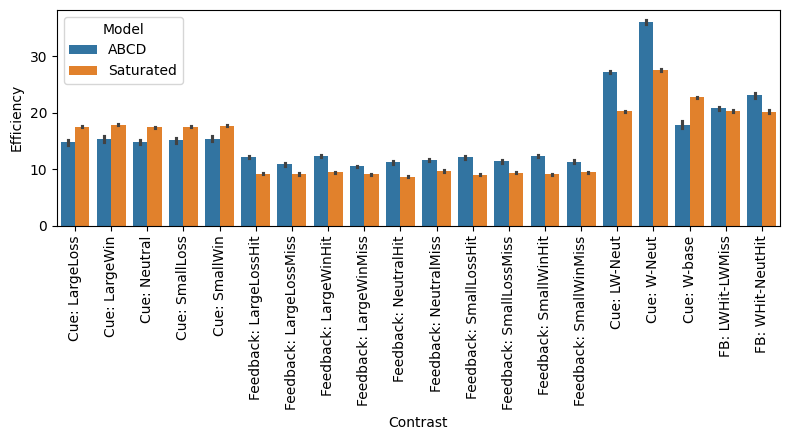

In [26]:
# eff_dat_no_cue_fix = eff_dat_plot.copy()
fig_path = f'{figure_output_path}/eff_barplot.pdf'

eff_trimmed = eff_dat_plot[
    ~eff_dat_plot['contrast'].str.contains('Fixation|Deriv|Probe')
]
eff_trimmed = eff_trimmed[~eff_trimmed['contrast'].str.contains('derivative|constant')]
eff_trimmed = eff_trimmed[~eff_trimmed['model'].str.contains('CueNoDeriv')]
eff_trimmed = eff_trimmed[eff_trimmed['Jitter'] == 'No Jitter']
eff_trimmed['model'] = eff_trimmed['model'].str.replace('CueYesDeriv', 'ABCD')
eff_trimmed = eff_trimmed.rename(
    {'model': 'Model', 'efficiency': 'Efficiency', 'contrast': 'Contrast'},
    axis=1,
)

eff_trimmed_not_cons = eff_trimmed[~eff_trimmed['Contrast'].str.contains('-')]

eff_trimmed_cons = eff_trimmed[eff_trimmed['Contrast'].str.contains('-')]
eff_trimmed_cons = eff_trimmed_cons.sort_values(by='Contrast')
eff_plot = pd.concat([eff_trimmed_not_cons, eff_trimmed_cons])

hue_order = [f'{model}' for model in ['ABCD', 'Saturated']]


fig = plt.subplots(1, 1, figsize=(8, 4.5))
sns.barplot(
    data=eff_plot,
    x='Contrast',
    y='Efficiency',
    hue='Model',
    hue_order=hue_order,
)
# plt.ylim(0,.01)
plt.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

In [27]:
mean_efficiency_saturated = (
    eff_trimmed[eff_trimmed['Model'] == 'Saturated']
    .groupby('Contrast')['Efficiency']
    .mean()
)
mean_efficiency_abcd = (
    eff_trimmed[eff_trimmed['Model'] == 'ABCD'].groupby('Contrast')['Efficiency'].mean()
)

print(mean_efficiency_saturated / mean_efficiency_abcd)
print(np.max(mean_efficiency_saturated / mean_efficiency_abcd))
print(np.min(mean_efficiency_saturated / mean_efficiency_abcd))

Contrast
Cue: LW-Neut               0.744647
Cue: LargeLoss             1.188299
Cue: LargeWin              1.168391
Cue: Neutral               1.177742
Cue: SmallLoss             1.160785
Cue: SmallWin              1.152914
Cue: W-Neut                0.764460
Cue: W-base                1.271220
FB: LWHit-LWMiss           0.976933
FB: WHit-NeutHit           0.874308
Feedback: LargeLossHit     0.763402
Feedback: LargeLossMiss    0.842950
Feedback: LargeWinHit      0.764282
Feedback: LargeWinMiss     0.868463
Feedback: NeutralHit       0.772100
Feedback: NeutralMiss      0.833833
Feedback: SmallLossHit     0.743944
Feedback: SmallLossMiss    0.823402
Feedback: SmallWinHit      0.738543
Feedback: SmallWinMiss     0.829068
Name: Efficiency, dtype: float64
1.2712197387138182
0.7385432326989037
